In [1]:
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pystan
import seaborn as sns
import scipy as sp

#### Import stan convergence utilities from local directory 
Utilities originally by Betancourt, [see this notebook on Bayesian workflow](http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html).

In [2]:
%run utility/stan_utility.py

#### Import data

In [3]:
names = ['streams', 'acousticness', 'danceability', 'energy', 'loudness', 'tempo', 'valence']
global_data  = pd.read_csv('./data/global_selected.csv',header=None, names=names)
finland_data = pd.read_csv('./data/finland_selected.csv',header=None, names=names)
sweden_data  = pd.read_csv('./data/sweden_selected.csv',header=None, names=names)

#### Methods for saving and loading models

In [4]:
def save_model(model, filename):
    """Saves the compiled model to file."""
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

def load_model(filename):
    """Load already compiled model from file."""
    return pickle.load(open(filename, 'rb'))

# __Bayesian Inference on Spotify Streams__ | Models
## __Introduction__
This notebook contains the modeling for our `Bayesian Data Analysis`-course project.
#### This notebook is structured in a following way:
1. __Introducing bayesian linear regression model__
2. __Modeling and inference__ 
    1. 3-covariate model with uninformative priors
    2. 3-covariate model with normal priors
    3. 5-covariate model with normal priors
    4. Extended 5-covariate model with interaction terms
    5. Extended 5-covariate model with interaction terms and hierarchical prior
3. __Model comparison__
4. __Conclusions__

## __1. Introducing Bayesian Linear Regression Model__
#### __Motivation__ 
We are interested in finding out which features in the spotify's song data determine the number of streams in Spotify. We will study this hypothesis by using multiple linear models which model the linear relationship between the variable that includes data about the number of streams with other variables which we use as predictors.

#### __Assumptions__
We first assume that the relationship between $d$-dimension predictor variables $X = \{X_1,X_2,...,X_d\}$ each having $n$ elements, and observations $Y = \{y_1,y_2,...,y_n\}$ (streams) is modeled by *linear dependence*. We also assume that all elements $y \in Y$ and $x \in X$ are independent of each other. 

The mean $\mu$ of model is described by: $\mu = \mathbb{E}[y_i \mid \beta, X] = \alpha + \beta_1 X_1 + \beta_2 X_2 + , ... , + \beta_d X_d$, where $\alpha$ is the intercept and $\beta = \{\beta_1, \beta_2, ... , \beta_d\}$ the parameter vector for coefficients.

We also need to consider the unknown error term $\sigma$. Thus in general form our model is of the form:  

$$\large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_d X_d, \;\sigma)$$

In bayesian context we are not interested about point-estimate, but rather the whole posterior distribution which takes the form:

$$\large p(\beta \mid y, X) = \frac{p(y \mid \beta,X)p(\beta\mid X)}{p(y\mid X)}$$

#### __Scaling streaming data__
For easier interpretability we will scale streams to interval $[0,1]$ which means that any $y$ is measured in proportion to the highest performing song.

In [7]:
stream_global_max = np.max(global_data['streams'])
for data in [global_data, finland_data, sweden_data]:
    data['streams'] = data['streams'].values / stream_global_max

## __2. Modeling and Inference__

In this notebook each model will go through following stages:     
  * Picking suitable priors
  * Convergence diagnostics
  * Sensitivity analysis
  * Predictive distribution checking
  * Model evaluation

## __2.1 Uninformative model__ | Three predictors with uninformative priors
For the first model we select only three of the predictor variables based on 1) feature importance based on random forest (pre-processing-notebook) 2) collinearity (EDA-notebook) -- because of the assumptions of the linear model, we want to avoid highly collinear pairs such as `loudness ~ energy` and `valence` which is potentially collinear with many other covariates. Following predictors for this models are `danceability, acousticness` and `tempo`. 

Complete model takes the form:

$$ \large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3, \;\sigma)$$


We start the modeling with uninformative priors. This type of simple model gives us a crude picture of what the bayesian inference can tell us about the data, and it gives us a reference model which we can then compare the more complex models on.  
Here we let Stan take care of the priors, and it chooses __*uniform priors by default*__. This is also known as the *ordinary linear regression*:

### __Load model__

In [11]:
filename = 'lin_3_uninformative.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // tempo
    
    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred; 
}

parameters{
    real a;
    vector[3] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3;
}

model{
    y ~ normal(mu, sigma);
}

generated quantities{
    vector[Npred] ypred;
    vector[N] log_lik;
    
    for (j in 1:N){ 
        // logarithmic likelihood for streams (PSIS-LOO)
        log_lik[j] = normal_lpdf(y[j] | mu, sigma);
    }
    
    for (j in 1:Npred){
        // prediction for year 2018
        ypred[j] = normal_rng(a + b[1]*X1pred[j] + b[2]*X2pred[j] + b[3]*X3pred[j], sigma);
    } 
 
}


In [12]:
gb_2017 = global_data.values
gb_2018 = global_data.values # We need to query the API for 2018 data and pre-process it. Finnish data is used for demonstration. 
data = dict(N=gb_2017.shape[0],y=gb_2017[:,0],X1=gb_2017[:,1], X2=gb_2017[:,2], X3=gb_2017[:,5],
            Npred=gb_2018.shape[0], X1pred=gb_2018[:,1], X2pred=gb_2018[:,2], X3pred=gb_2018[:,5])

### __Fit model__

In [13]:
# Load compiled model if available
fit = None
try:
  fit = load_model('lin_3_uninformative.stan.saved')
except Exception: 
  fit = pystan.stan(file=filename, data=data, seed=42)
  save_model(fit, filename + '.saved')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_292039ab535cf44cf201c28c58f22d90 NOW.
/home/zenist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  after removing the cwd from sys.path.


In [14]:
samples = fit.extract(permuted=True)

### __Simulation results__ | Posterior

In [15]:
summary = fit.summary(pars = ['a','b','sigma','ypred',]) 
fit_sum = pd.DataFrame(summary['summary'],
                  index=summary['summary_rownames'],
                  columns = summary['summary_colnames'])

fit_sum.iloc[0:10,0:10]

mean   se_mean        sd      2.5%       25%       50%  \
a         0.270837  0.000177  0.012441  0.246649  0.262619  0.270714   
b[1]      0.013580  0.000196  0.012808 -0.011743  0.005000  0.013314   
b[2]     -0.000398  0.000200  0.013793 -0.028228 -0.009394 -0.000315   
b[3]      0.008500  0.000204  0.013426 -0.017563 -0.000489  0.008419   
sigma     0.122438  0.000150  0.009091  0.105869  0.116092  0.121872   
ypred[1]  0.299784  0.002134  0.126466  0.046426  0.216266  0.300415   
ypred[2]  0.289057  0.002102  0.127269  0.044842  0.203381  0.286800   
ypred[3]  0.290021  0.002040  0.125805  0.042950  0.207094  0.289673   
ypred[4]  0.258858  0.002072  0.122802  0.016912  0.176592  0.257886   
ypred[5]  0.251106  0.001949  0.122821  0.016199  0.165497  0.249570   

               75%     97.5%        n_eff      Rhat  
a         0.279328  0.295191  4961.735343  0.999447  
b[1]      0.022463  0.038011  4282.662540  0.999671  
b[2]      0.008882  0.026413  4740.499011  0.999530  
b[3]      0.017451  0.035543  4323.503603  0.999792  
sigma     0.128141  0.141802  3652.310655  0.999714  
ypred[1]  0.383824  0.552790  3513.002720  0.999434  
ypred[2]  0.372787  0.546291  3666.785908  0.999793  
ypred[3]  0.373695  0.536456  3802.786751  0.999627  
ypred[4]  0.342368  0.499728  3512.537290  0.999584  
ypred[5]  0.332181  0.492026  3970.793253  1.000454

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f447cfe0978>,
      dtype=object)

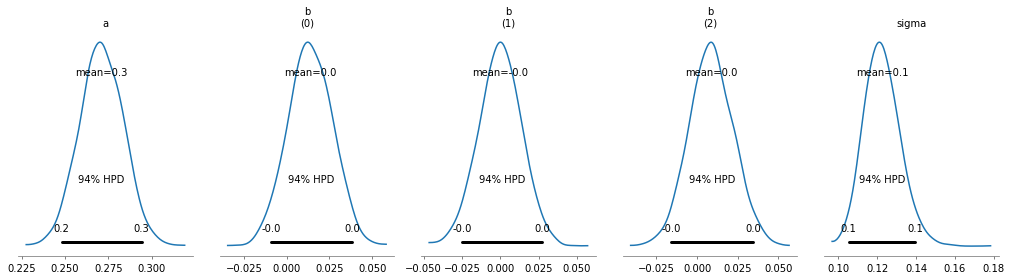

In [16]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])

azpos = azfit.posterior.drop(['mu','log_lik'])
az.plot_posterior(azpos, figsize=(14,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f447cf32470>,
      dtype=object)

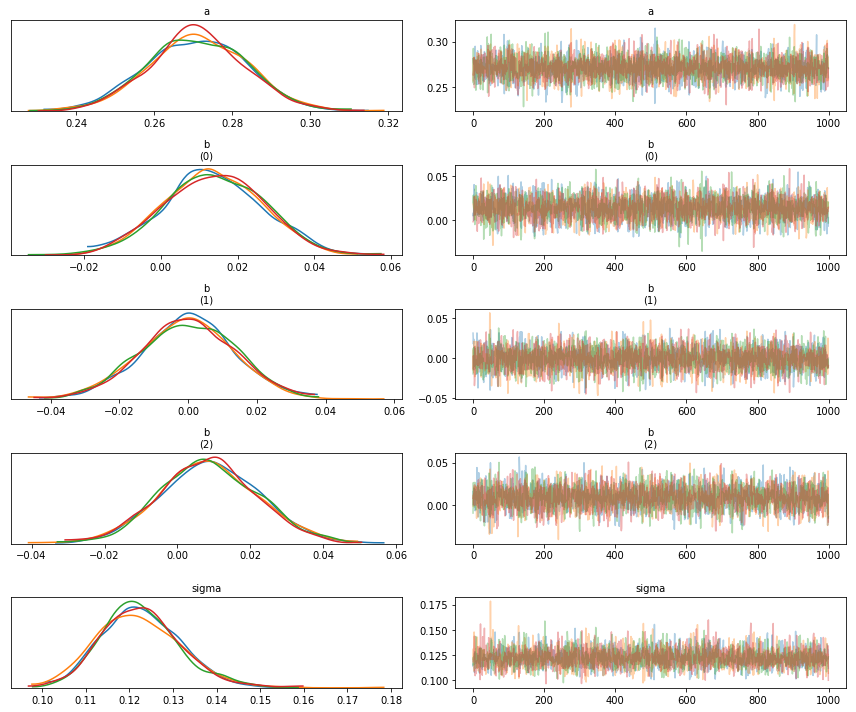

In [17]:
az.plot_trace(azpos)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4479467f60>, GridSpec(4, 4))

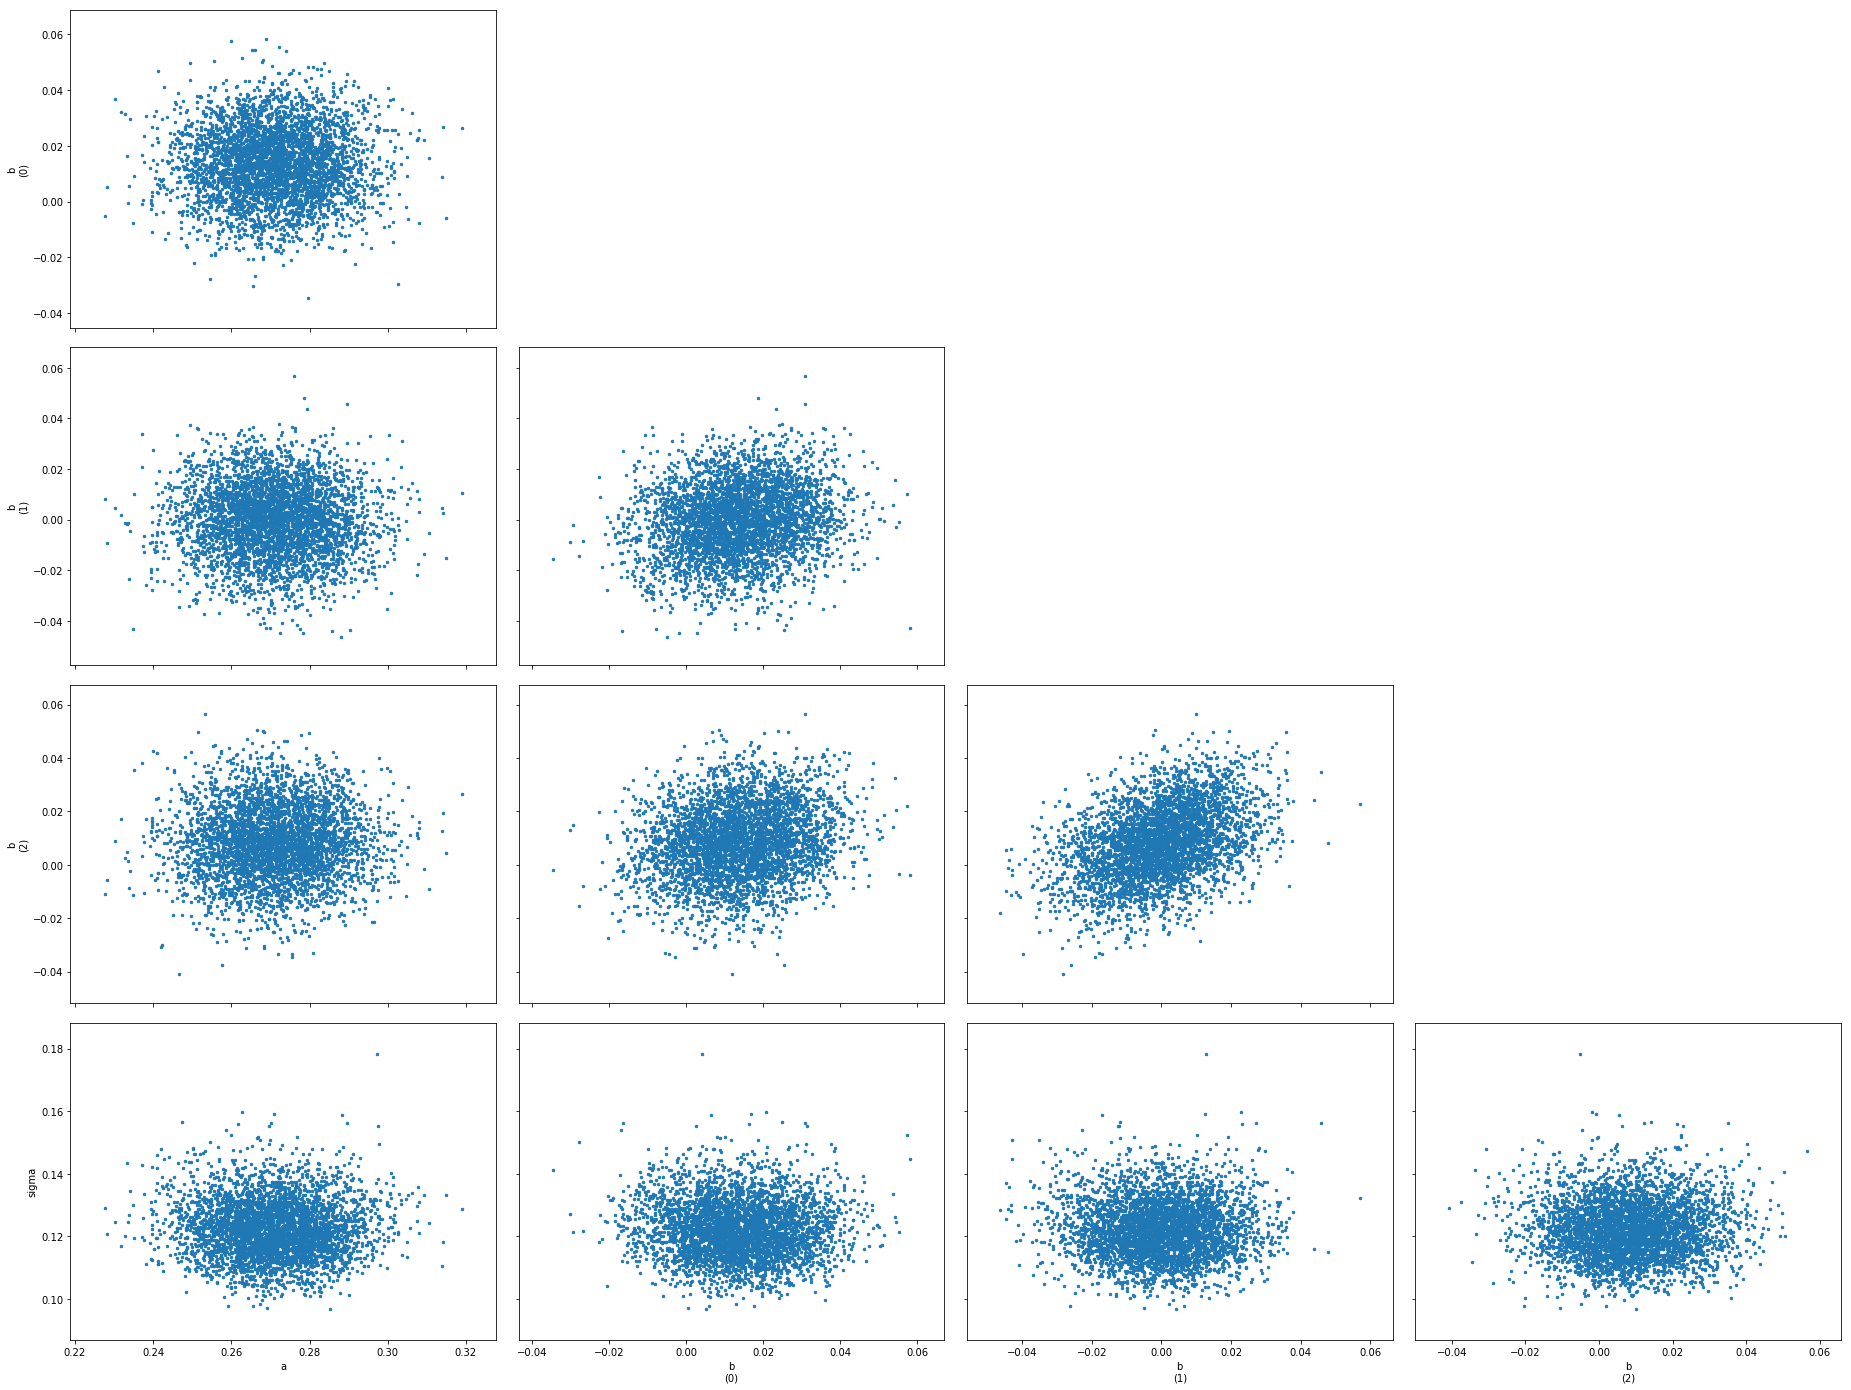

In [18]:
az.plot_pair(azpos)

### __Model check__ | PSIS-LOO

In [19]:
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data='y', 
                       posterior_predictive='ypred', 
                       log_likelihood='log_lik')
az.loo(azfit)

/home/zenist/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
/home/zenist/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
        influential observations.
  influential observations."""


loo       loo_se        p_loo  warning
0 -5407.238592  5546.962048  7236.900066        1

### __Predictive accuracy__ | Predict streams for 2018 top 100 

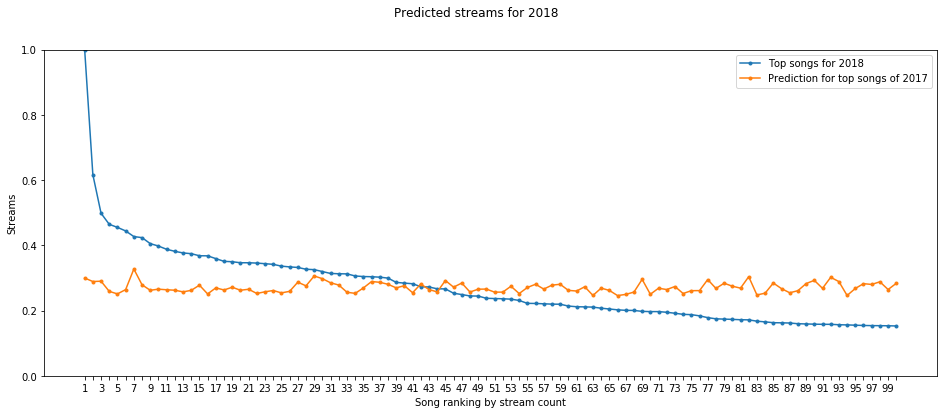

In [20]:
plt.figure(figsize=(16,6))

plt.suptitle('Predicted streams for 2018')
plt.xlabel('Song ranking by stream count')
plt.ylabel('Streams')

plt.ylim(0,1)
plt.xticks(range(1,101),labels=['{0}'.format(i) if i % 2 != 0 else '' for i in range(1,101)])
X_top100 = range(1,101)

plt.plot(X_top100, global_data['streams'], '.-', label='Top songs for 2018')
plt.plot(X_top100, np.mean(samples['ypred'], axis=0),  '.-', label='Prediction for top songs of 2017')
plt.legend(loc='best')

## __2.2 Weakly Informative model 1__ | Three predictors with normal priors
One of the common priors for linear regression is Zellner's g-prior with independent Gaussian priors such that for each $j \mid 1 \leq j \leq d$ and $\beta_j \sim N(0, \frac{\sigma^2}{g})$ and often the unit information prior $g = 1 / n$ is used.

For the second model we add normal priors, thus making the model normal linear model.
Complete model takes the form:

$$ \large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3, \;\sigma)$$

Now we also assume independent prior distributions following Zellner's g-prior for $\alpha$ and $\beta_j$'s such that $\alpha \sim N(0, 100\sigma_0^2)$, and $\beta_j \sim N(0, 100\sigma_0^2)$, where $1 \leq j \leq 3$.

### __Load model__

In [21]:
filename = 'lin_3_informative.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // tempo
    
    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    
    // prior means 
    real mu_a;
    vector[3] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[3] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3;
}

model{
    a ~ normal(mu_a, sigma_0);
    b ~ normal(mu_b, sigma_0);
    y ~ normal(mu, sigma);
}

generated quantities{
    vector[Npred] ypred;
    vector[N] log_lik;
    
    for (j in 1:N){ 
        // logarithmic likelihood for streams (PSIS-LOO)
        log_lik[j] = normal_lpdf(y[j] | mu, sigma);
    }
    
    for (j in 1:Npred){
        // prediction for year 2018
        ypred[j] = norma

In [22]:
gb_2017 = global_data.values
gb_2018 = global_data.values 

data = dict(N=gb_2017.shape[0],y=gb_2017[:,0],X1=gb_2017[:,1], X2=gb_2017[:,2], X3=gb_2017[:,5],
            Npred=gb_2018.shape[0], X1pred=gb_2018[:,1], X2pred=gb_2018[:,2], X3pred=gb_2018[:,5],
            mu_a= 0,
            mu_b= [0,0,0],
            sigma_0= 0.12*10) # Approximate the uninformative model's results x 10 following Zellner's prior

### __Fit model__

In [23]:
# Load compiled model if available
fit = None
try:
  fit = load_model('lin_3_informative.stan.saved')
except Exception: 
  fit = pystan.stan(file=filename, data=data, seed=42)
  save_model(fit, filename + '.saved')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b2bdd4d277607f22040bb0d07bed2817 NOW.
/home/zenist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  after removing the cwd from sys.path.


In [24]:
samples = fit.extract(permuted=True)

### __Simulation results__ | Posterior

In [25]:
summary = fit.summary(pars = ['a','b','sigma','ypred',]) 
fit_sum = pd.DataFrame(summary['summary'],
                  index=summary['summary_rownames'],
                  columns = summary['summary_colnames'])

fit_sum.iloc[0:10,0:10]

mean   se_mean        sd      2.5%       25%       50%  \
a         0.271192  0.000177  0.011985  0.247911  0.262991  0.271168   
b[1]      0.013551  0.000192  0.012622 -0.011752  0.005193  0.013481   
b[2]     -0.000511  0.000194  0.013552 -0.027474 -0.009532 -0.000621   
b[3]      0.008627  0.000204  0.013774 -0.018734 -0.000861  0.008667   
sigma     0.122575  0.000137  0.008836  0.106777  0.116230  0.122023   
ypred[1]  0.296838  0.002054  0.129681  0.048340  0.209153  0.295797   
ypred[2]  0.291337  0.001998  0.126468  0.041296  0.208754  0.290589   
ypred[3]  0.290300  0.001961  0.124234  0.047322  0.207156  0.290818   
ypred[4]  0.256355  0.001899  0.123628  0.018819  0.173694  0.257388   
ypred[5]  0.253471  0.001993  0.126068  0.008444  0.170281  0.255690   

               75%     97.5%        n_eff      Rhat  
a         0.279180  0.294683  4566.283046  0.999469  
b[1]      0.021980  0.038165  4305.231567  0.999166  
b[2]      0.008861  0.025898  4860.041449  1.000115  
b[3]      0.017914  0.035226  4563.029327  1.001167  
sigma     0.128371  0.141114  4149.060010  1.000198  
ypred[1]  0.384419  0.551440  3987.342258  1.000222  
ypred[2]  0.375582  0.535554  4007.381098  0.999752  
ypred[3]  0.374055  0.530512  4012.443947  1.000188  
ypred[4]  0.342203  0.498886  4236.816606  0.999792  
ypred[5]  0.336776  0.497332  4001.945045  0.999451

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4478798b70>,
      dtype=object)

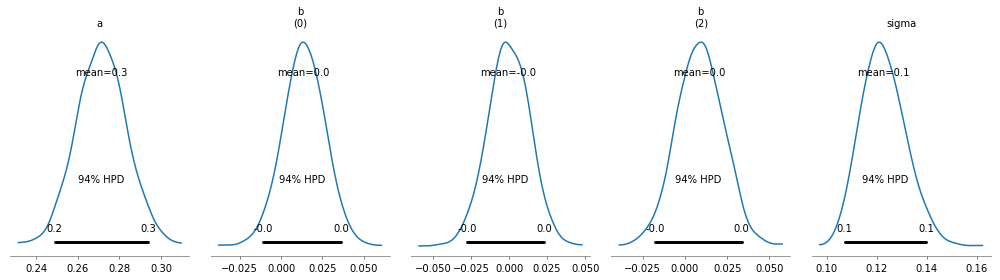

In [26]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
azpos = azfit.posterior.drop(['mu','log_lik'])
az.plot_posterior(azpos, figsize=(14,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f447838a2e8>,
      dtype=object)

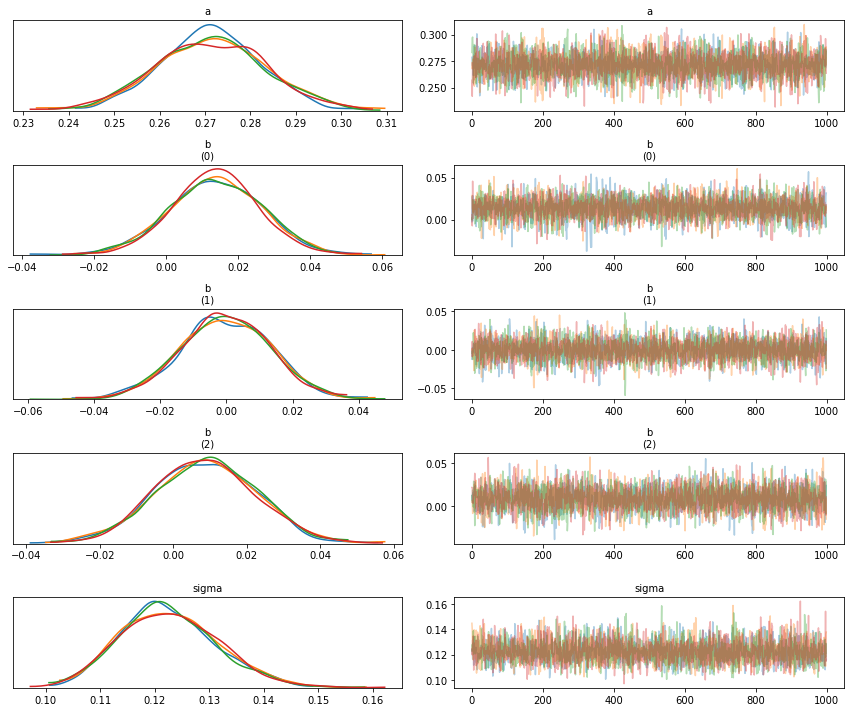

In [27]:
az.plot_trace(azpos)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f447d2a2f60>, GridSpec(4, 4))

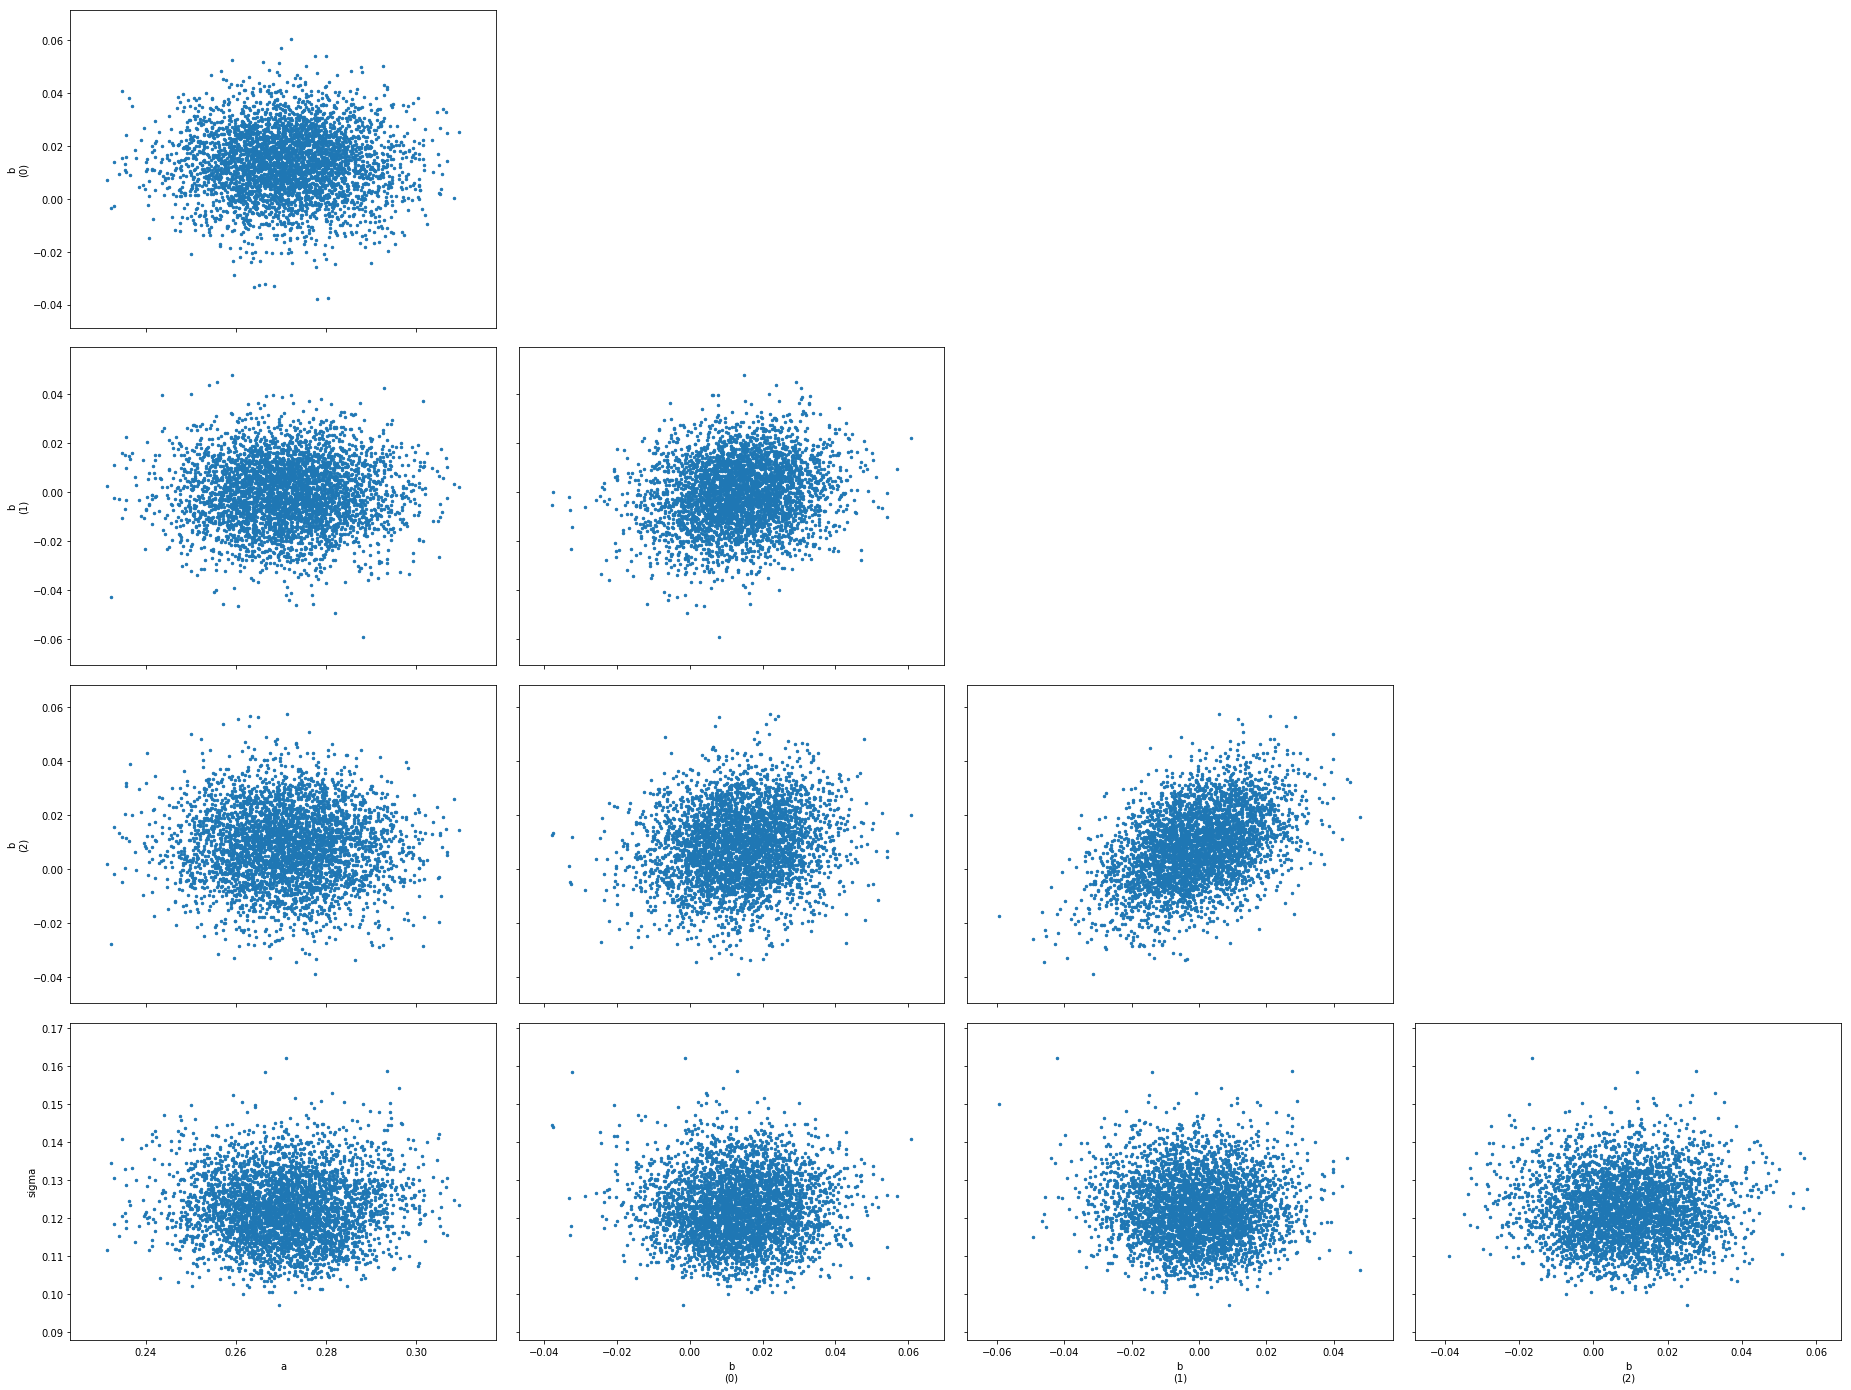

In [28]:
az.plot_pair(azpos)

### __Model check__ | PSIS-LOO

In [29]:
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data='y', 
                       posterior_predictive='ypred', 
                       log_likelihood='log_lik')
az.loo(azfit)

/home/zenist/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
/home/zenist/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
        influential observations.
  influential observations."""


loo       loo_se        p_loo  warning
0 -6317.599543  5485.021601  6477.133081        1

### __Predictive accuracy__ | Predict streams for 2018

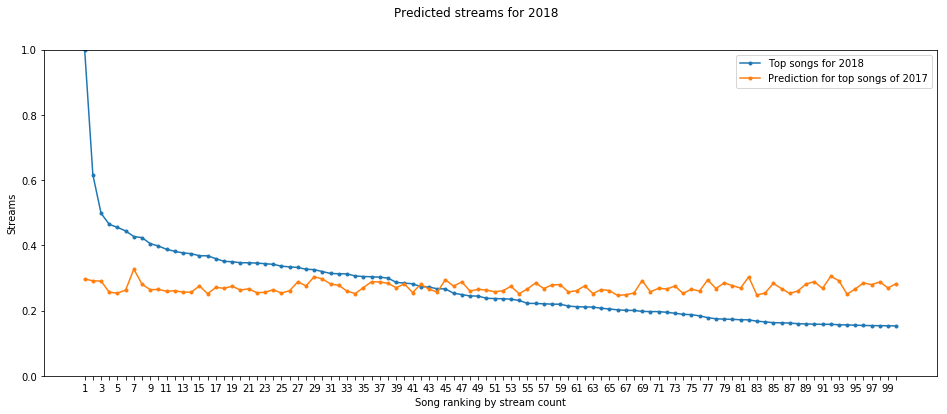

In [30]:
plt.figure(figsize=(16,6))

plt.suptitle('Predicted streams for 2018')
plt.xlabel('Song ranking by stream count')
plt.ylabel('Streams')

plt.ylim(0,1)
plt.xticks(range(1,101),labels=['{0}'.format(i) if i % 2 != 0 else '' for i in range(1,101)])
X_top100 = range(1,101)

plt.plot(X_top100, global_data['streams'], '.-', label='Top songs for 2018')
plt.plot(X_top100, np.mean(samples['ypred'], axis=0),  '.-', label='Prediction for top songs of 2017')
plt.legend(loc='best')

## __2.3 Weakly Informative Model 2__ | Five predictors with normal priors
In hope of better results, we will extend the model to include other covariates except energy which based on the exploratory data analysis is strongly collinear with 'loudness' and thus would not satisfy the linearity assumptions of our model. 

Third model will have 5 predictors with normal priors.
Complete model takes the form:

$$ \large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5, \;\sigma)$$

We also extend our priors accordingly.

### __Load model__

In [31]:
filename = 'lin_5_informative.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // loudness
    vector[N] X4; // tempo
    vector[N] X5; // valence

    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    vector[Npred] X4pred;
    vector[Npred] X5pred;
    
    // prior means 
    real mu_a;
    vector[5] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[5] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3 + b[4]*X4 + b[5]*X5;
}

model{
    a ~ normal(mu_a, sigma_0);
    b ~ normal(mu_b, sigma_0);    
    y ~ normal(mu, sigma);
}

generated quantities{
    vector[Npred] ypred;
    vector[N] log_lik;
    
    for (j in 1:N){ 
        // logarithmic likelihood for streams (PSIS-LOO)
        log_lik[

In [32]:
gb_2017 = global_data.values
gb_2018 = global_data.values # We need to query the API for 2018 data and pre-process it. Finnish data is used for demonstration. 
data = dict(N=gb_2017.shape[0],
            y=gb_2017[:,0],
            X1=gb_2017[:,1], X2=gb_2017[:,2], X3=gb_2017[:,4], X4=gb_2017[:,5], X5=gb_2017[:,6],
            Npred=gb_2018.shape[0], 
            X1pred=gb_2018[:,1], X2pred=gb_2018[:,2], X3pred=gb_2018[:,4], X4pred=gb_2018[:,5], X5pred=gb_2018[:,6],
            mu_a=0,
            mu_b=[0,0,0,0,0],
            sigma_0=0.12*10) # Approximately the first model's result for std of priors x 2

### __Fit model__

In [33]:
# Load compiled model if available
fit = None
try:
  fit = load_model('lin_5_informative.stan.saved')
except Exception: 
  fit = pystan.stan(file=filename, data=data, seed=42)
  save_model(fit, filename + '.saved')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9e12de3a3b666024c75563a0229d8c62 NOW.
/home/zenist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  after removing the cwd from sys.path.


In [34]:
samples = fit.extract(permuted=True)

### __Simulation results__ | Posterior

In [35]:
summary = fit.summary(pars = ['a','b','sigma','ypred',]) 
fit_sum = pd.DataFrame(summary['summary'],
                  index=summary['summary_rownames'],
                  columns = summary['summary_colnames'])

fit_sum.iloc[0:10,0:10]

mean   se_mean        sd      2.5%       25%       50%  \
a         0.270827  0.000160  0.012157  0.247550  0.262636  0.270808   
b[1]      0.013269  0.000188  0.013239 -0.012080  0.004275  0.013367   
b[2]     -0.004865  0.000236  0.014710 -0.033652 -0.014701 -0.005026   
b[3]      0.007401  0.000217  0.014021 -0.019332 -0.002273  0.007362   
b[4]      0.009990  0.000197  0.013401 -0.017330  0.001171  0.009962   
b[5]      0.016190  0.000218  0.014809 -0.013212  0.006471  0.015742   
sigma     0.121884  0.000132  0.009161  0.105583  0.115295  0.121338   
ypred[1]  0.329802  0.002022  0.130263  0.078984  0.242611  0.328532   
ypred[2]  0.325713  0.002033  0.126106  0.079186  0.237498  0.328858   
ypred[3]  0.323333  0.001984  0.126796  0.076211  0.240248  0.323667   

               75%     97.5%        n_eff      Rhat  
a         0.278747  0.295256  5789.332664  0.999781  
b[1]      0.021916  0.039518  4957.016982  0.999716  
b[2]      0.005148  0.024085  3877.912196  0.999989  
b[3]      0.017020  0.035164  4180.587816  0.999741  
b[4]      0.018764  0.036585  4643.075073  1.000370  
b[5]      0.026192  0.045070  4600.495784  0.999334  
sigma     0.127900  0.141218  4814.395149  0.999434  
ypred[1]  0.416270  0.595538  4151.063229  0.999470  
ypred[2]  0.412027  0.573635  3848.544713  0.999733  
ypred[3]  0.407186  0.576460  4083.122885  0.999248

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f447dc0d358>,
      dtype=object)

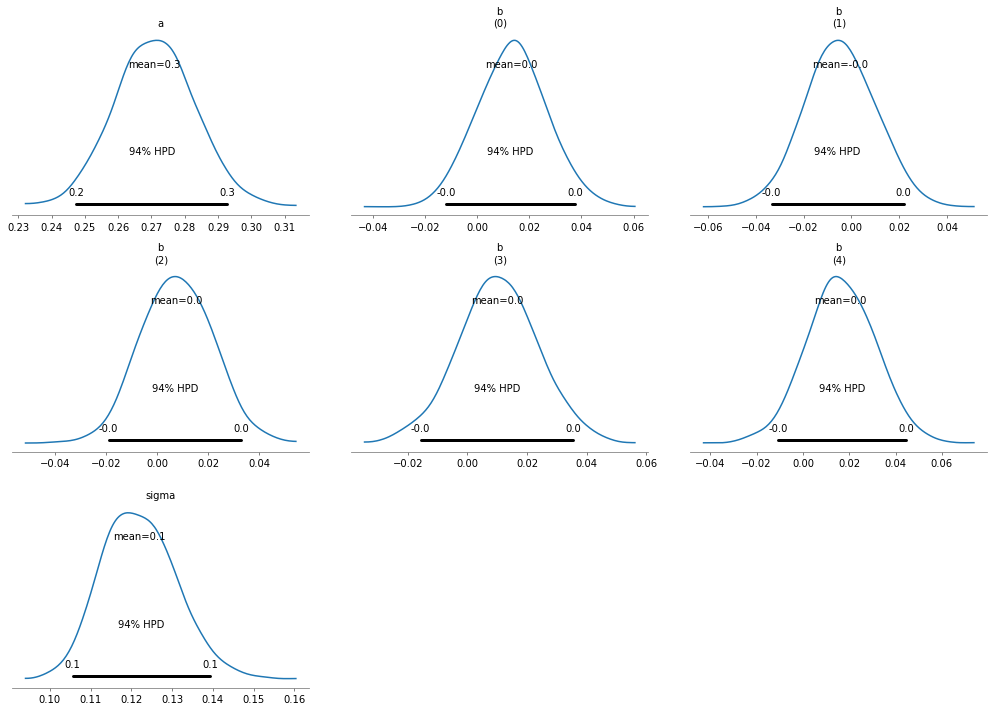

In [36]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
azpos = azfit.posterior.drop(['mu','log_lik'])
az.plot_posterior(azpos, figsize=(14,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f446a9d5b00>,
      dtype=object)

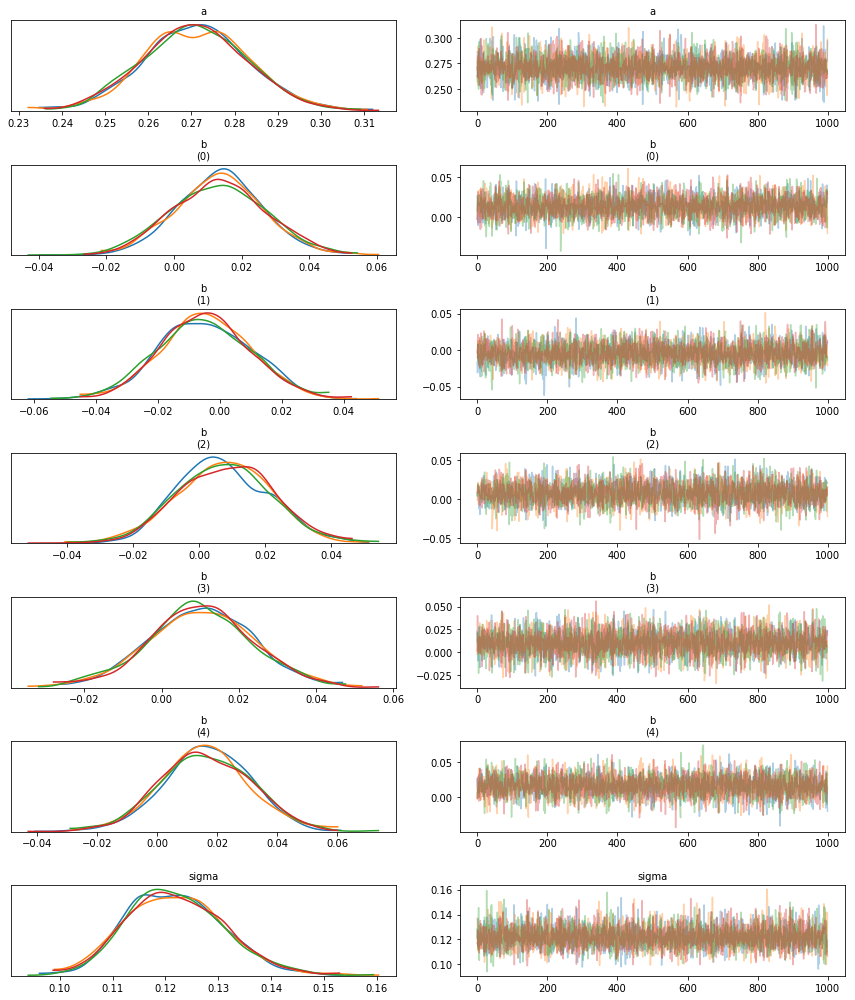

In [37]:
az.plot_trace(azpos)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f446a16d518>, GridSpec(6, 6))

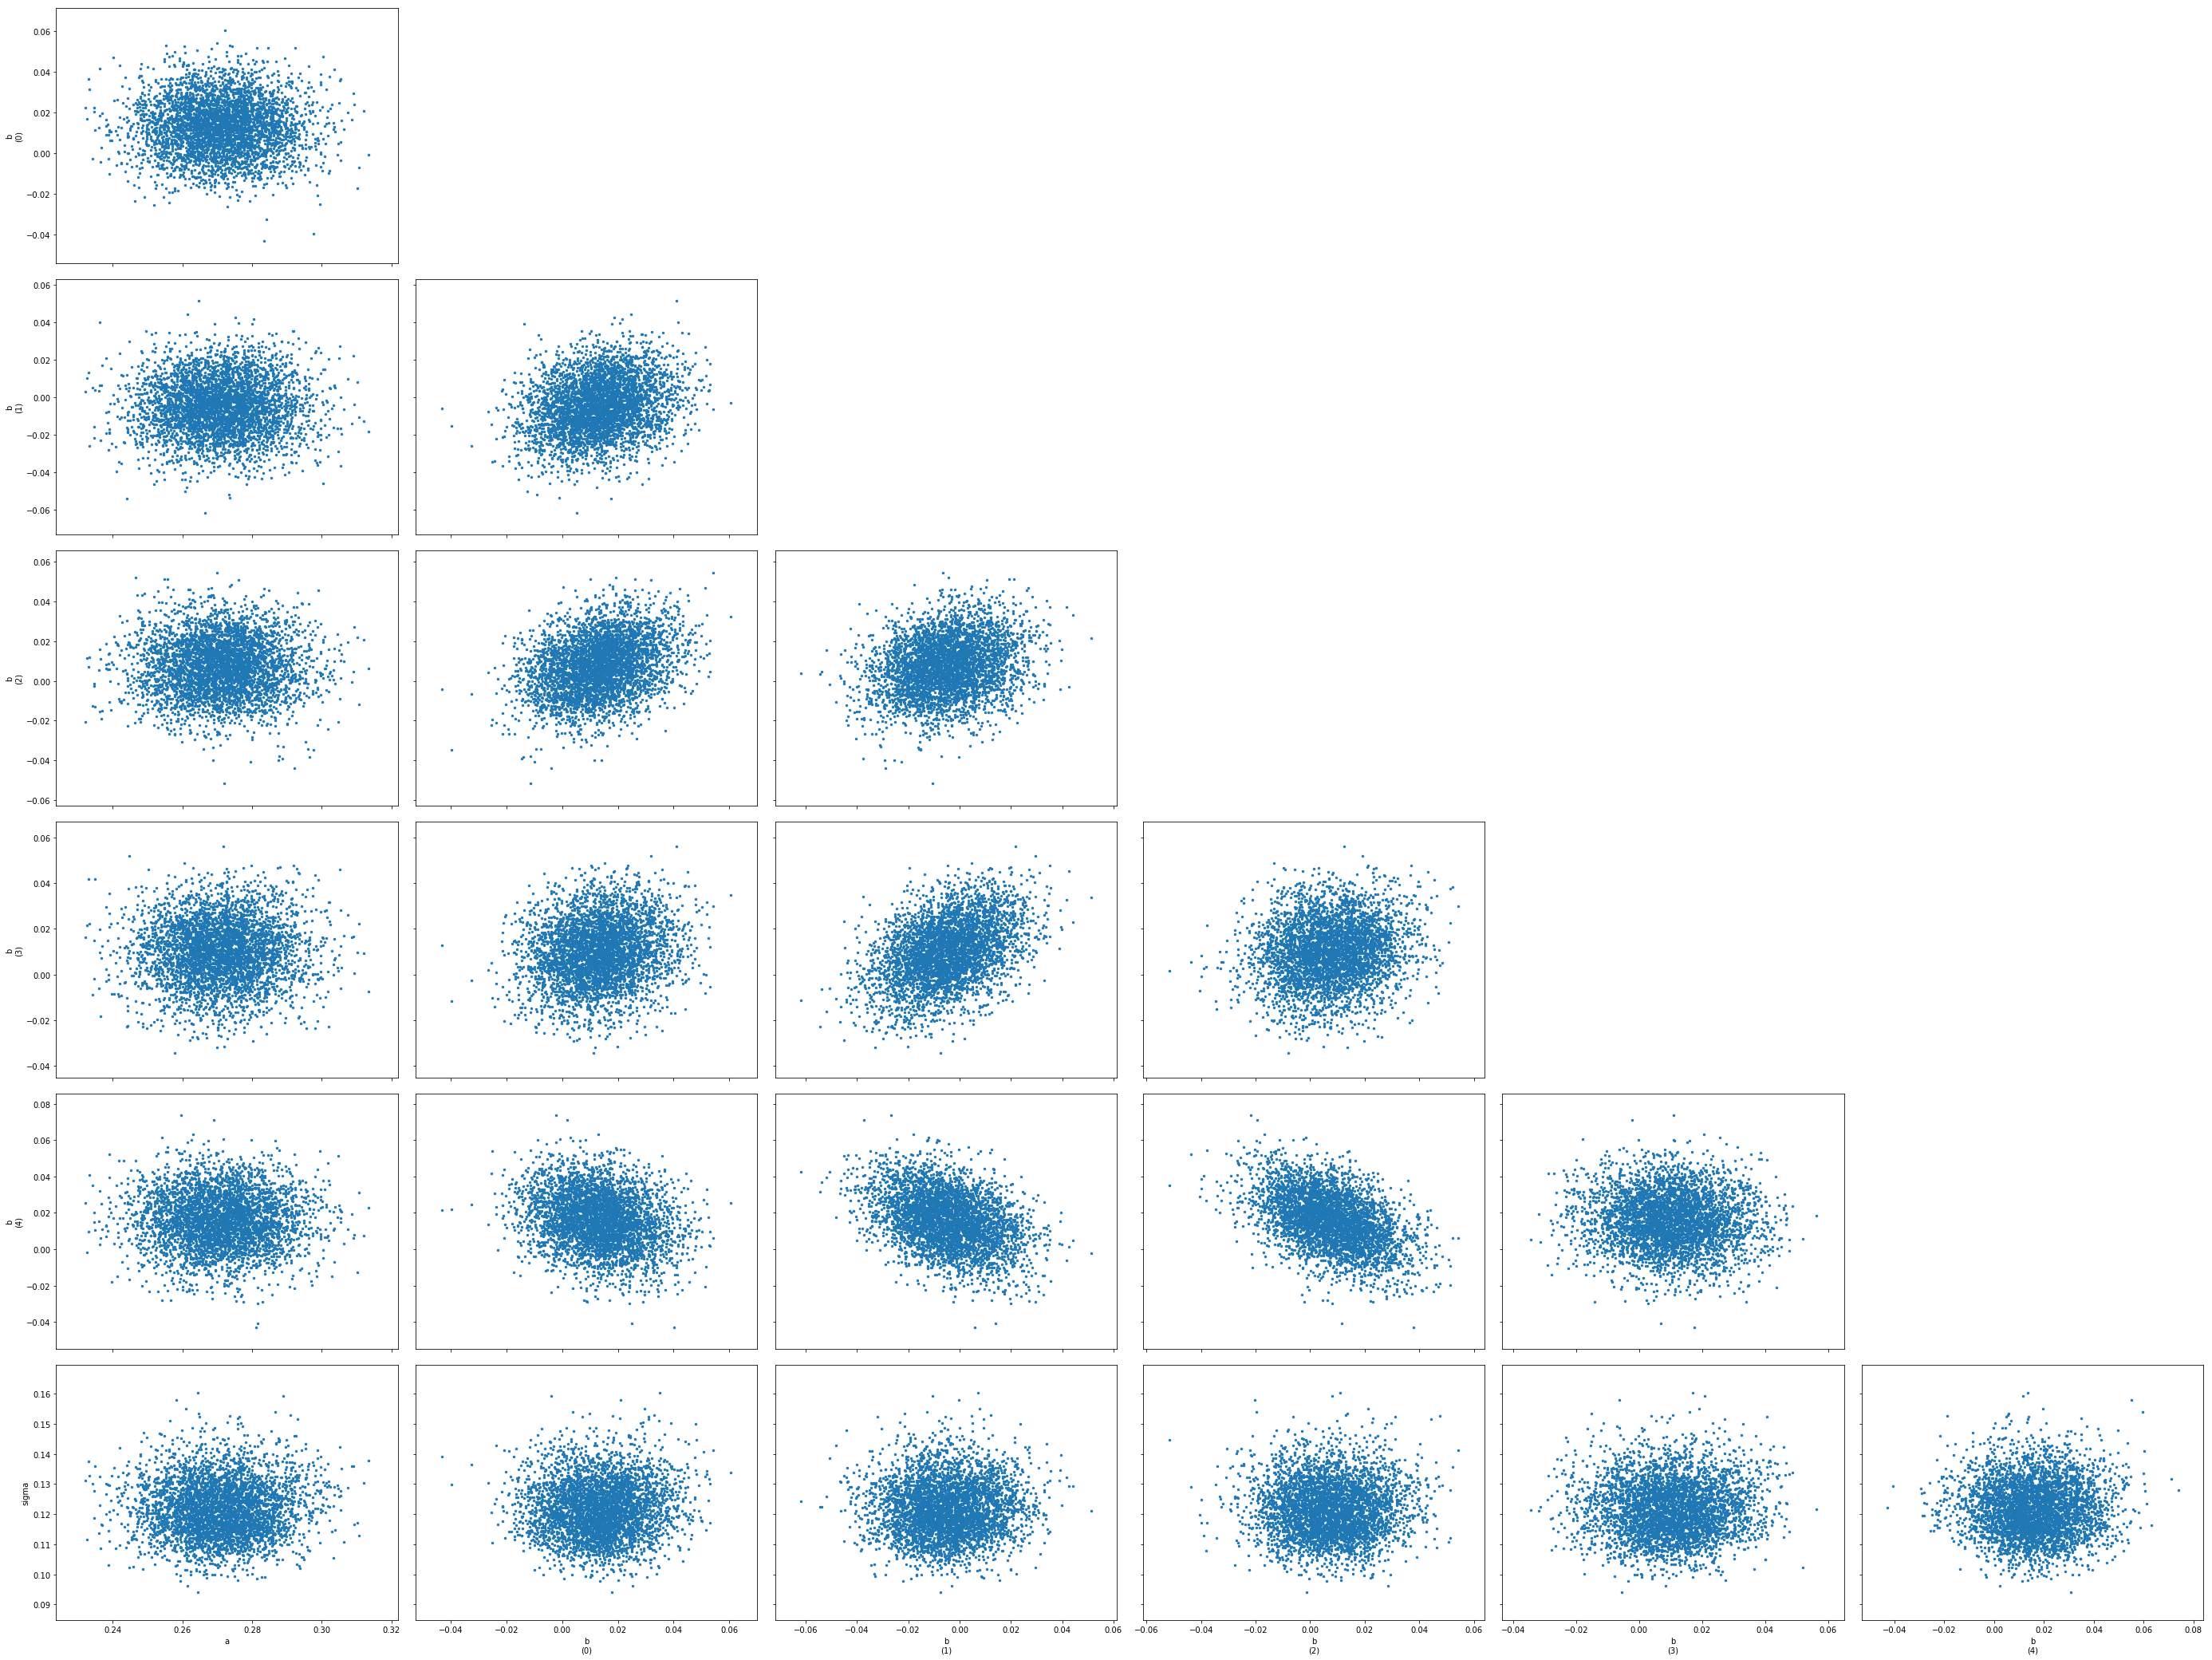

In [38]:
az.plot_pair(azpos)

### __Model check__ | PSIS-LOO

In [39]:
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data='y', 
                       posterior_predictive='ypred', 
                       log_likelihood='log_lik')
az.loo(azfit)

/home/zenist/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
/home/zenist/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
        influential observations.
  influential observations."""


loo       loo_se        p_loo  warning
0 -4801.452391  5885.211137  7154.993334        1

### __Predictive accuracy__ | Predict streams for 2018 top 100 

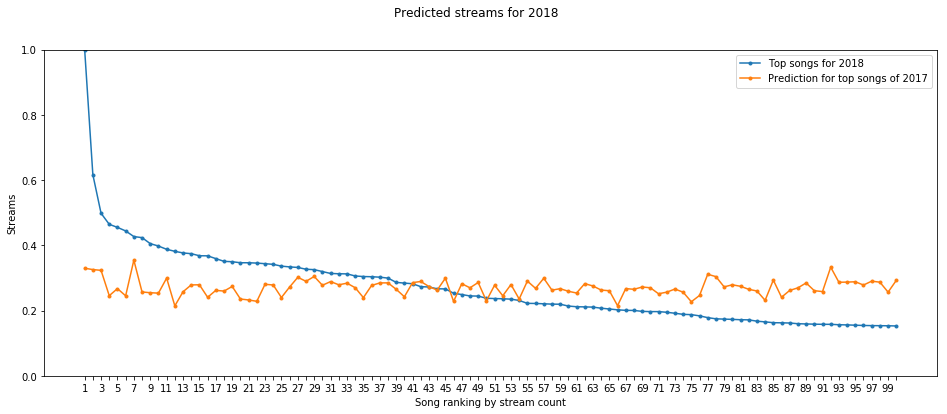

In [40]:
plt.figure(figsize=(16,6))

plt.suptitle('Predicted streams for 2018')
plt.xlabel('Song ranking by stream count')
plt.ylabel('Streams')

plt.ylim(0,1)
plt.xticks(range(1,101),labels=['{0}'.format(i) if i % 2 != 0 else '' for i in range(1,101)])
X_top100 = range(1,101)

plt.plot(X_top100, global_data['streams'], '.-', label='Top songs for 2018')
plt.plot(X_top100, np.mean(samples['ypred'], axis=0),  '.-', label='Prediction for top songs of 2017')
plt.legend(loc='best')

## __2.4 Extended model 1__ | Adding interaction terms
In the exploratory data analysis part of this analysis we identified multiple potential collinear relationships between covariates. We will now relax the linearity assumption of the model and introduce two new interaction terms. 

Interaction terms model:
1. potential positive collinearity between `valence` and `loudness`
2. negative collinearity between `tempo` and `danceability`.

This model will have 5 predictors with normal priors and altogether 7 parameters.
Complete model takes the form:

$$ \large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5 + \beta_6 X_2 X_4 + \beta_7 X_3 X_5, \;\sigma)$$

We also extend our Zellner's priors accordingly.

### __Load model__

In [41]:
filename = 'lin_5_informative-interaction.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // loudness
    vector[N] X4; // tempo
    vector[N] X5; // valence

    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    vector[Npred] X4pred;
    vector[Npred] X5pred;
    
    // prior means 
    real mu_a;
    vector[7] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[7] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    vector[N] X2X4;
    vector[N] X3X5;
    
    X2X4 = X2 .* X4;
    X3X5 = X3 .* X5;
    
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3 + b[4]*X4 + b[5]*X5 + b[6]*X2X4 + b[7]*X3X5;
}

model{
    a ~ normal(mu_a, sigma_0);
    b ~ normal(mu_b, sigma_0);
    y ~ normal(mu, sigma);
}

generated quantities{
    vector[Npred] ypred;
    vector

In [42]:
gb_2017 = global_data.values
gb_2018 = global_data.values # We need to query the API for 2018 data and pre-process it. Finnish data is used for demonstration. 
data = dict(N=gb_2017.shape[0],
            y=gb_2017[:,0],
            X1=gb_2017[:,1], X2=gb_2017[:,2], X3=gb_2017[:,4], X4=gb_2017[:,5], X5=gb_2017[:,6],
            Npred=gb_2018.shape[0], 
            X1pred=gb_2018[:,1], X2pred=gb_2018[:,2], X3pred=gb_2018[:,4], X4pred=gb_2018[:,5], X5pred=gb_2018[:,6],
            mu_a=0,
            mu_b=[0,0,0,0,0,0,0],
            sigma_0=0.12*10)

### __Fit model__

In [43]:
# Load compiled model if available
fit = None
try:
  fit = load_model('lin_5_informative-interaction.stan.saved')
except Exception: 
  fit = pystan.stan(file=filename, data=data, seed=42)
  save_model(fit, filename + '.saved')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9f4667fcc74979b58171eacadb9ab02d NOW.
/home/zenist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  after removing the cwd from sys.path.


In [44]:
samples = fit.extract(permuted=True)

### __Simulation results__ | Posterior

In [45]:
summary = fit.summary(pars = ['a','b','sigma','ypred',]) 
fit_sum = pd.DataFrame(summary['summary'],
                  index=summary['summary_rownames'],
                  columns = summary['summary_colnames'])

fit_sum.iloc[0:9,0:10]

mean   se_mean        sd      2.5%       25%       50%  \
a         0.267400  0.000182  0.013223  0.242442  0.258626  0.267165   
b[1]      0.014305  0.000180  0.012737 -0.011333  0.006050  0.014440   
b[2]     -0.009241  0.000231  0.015471 -0.040218 -0.019475 -0.009444   
b[3]      0.013154  0.000217  0.014234 -0.014748  0.003689  0.012914   
b[4]      0.021967  0.000230  0.015100 -0.007533  0.011646  0.021866   
b[5]      0.016292  0.000221  0.014410 -0.011434  0.006843  0.015950   
b[6]      0.016341  0.000172  0.011204 -0.006083  0.008937  0.016158   
b[7]      0.025336  0.000179  0.012535  0.000840  0.016970  0.025359   
sigma     0.119901  0.000119  0.008957  0.104307  0.113519  0.119188   
ypred[1]  0.371144  0.002041  0.129594  0.121137  0.284329  0.369590   

               75%     97.5%        n_eff      Rhat  
a         0.276221  0.293777  5262.676189  0.999721  
b[1]      0.022735  0.039012  5007.295305  0.999327  
b[2]      0.001113  0.021241  4487.905892  0.999530  
b[3]      0.022736  0.040303  4298.068065  0.999231  
b[4]      0.031994  0.051940  4314.483692  0.999680  
b[5]      0.025981  0.044959  4263.800801  0.999606  
b[6]      0.023935  0.038025  4265.843643  1.000305  
b[7]      0.033447  0.049930  4886.540916  1.000151  
sigma     0.125394  0.139020  5707.760001  0.999837  
ypred[1]  0.461025  0.620673  4029.807395  0.999734

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f446a4a7da0>,
      dtype=object)

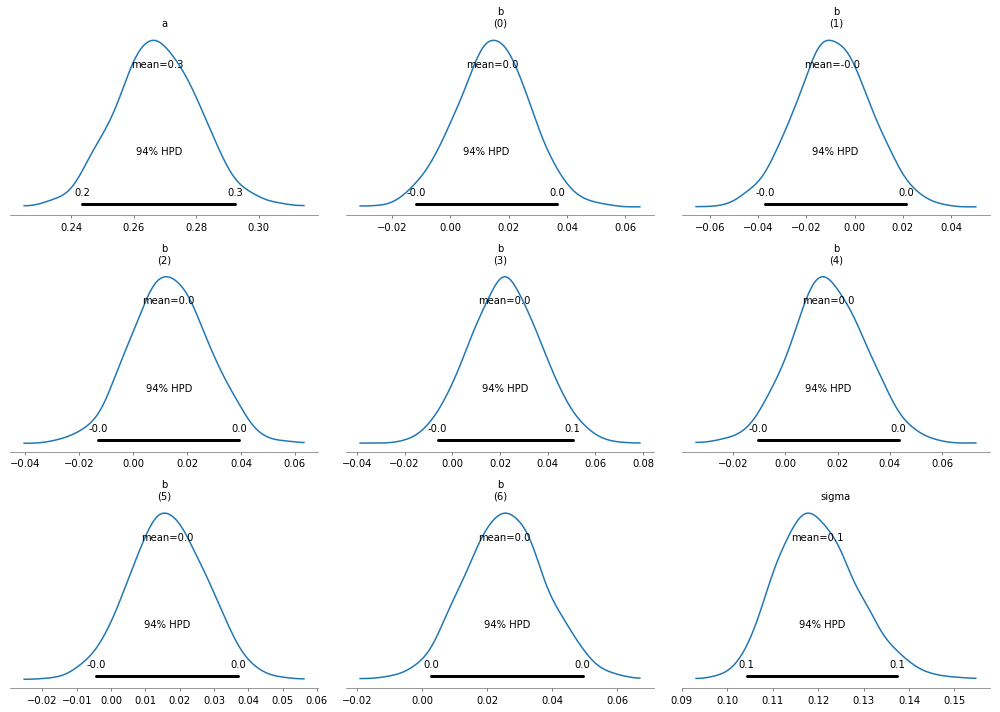

In [46]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
azpos = azfit.posterior[['a','b','sigma']]
az.plot_posterior(azpos, figsize=(14,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f446813abe0>,
      dtype=object)

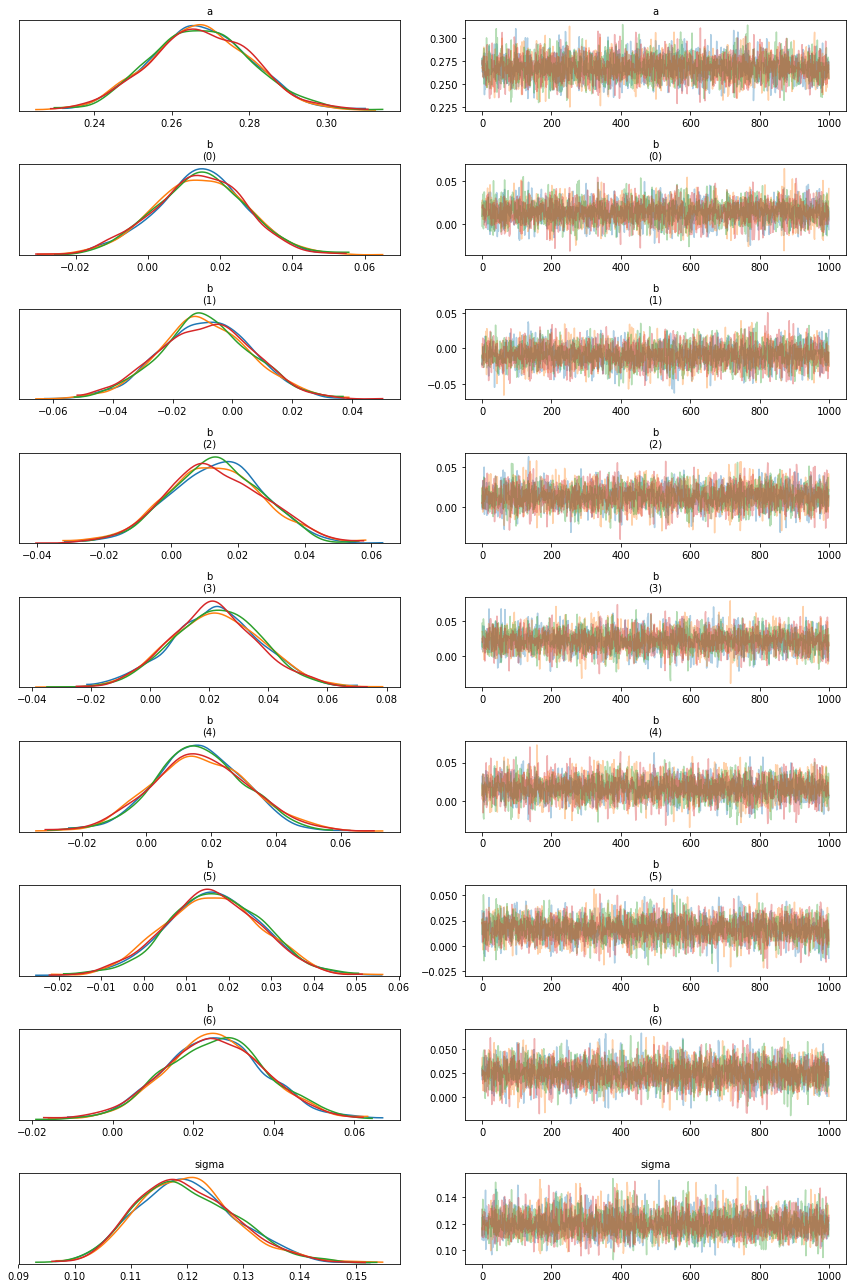

In [47]:
az.plot_trace(azpos)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f447c2b8cc0>, GridSpec(8, 8))

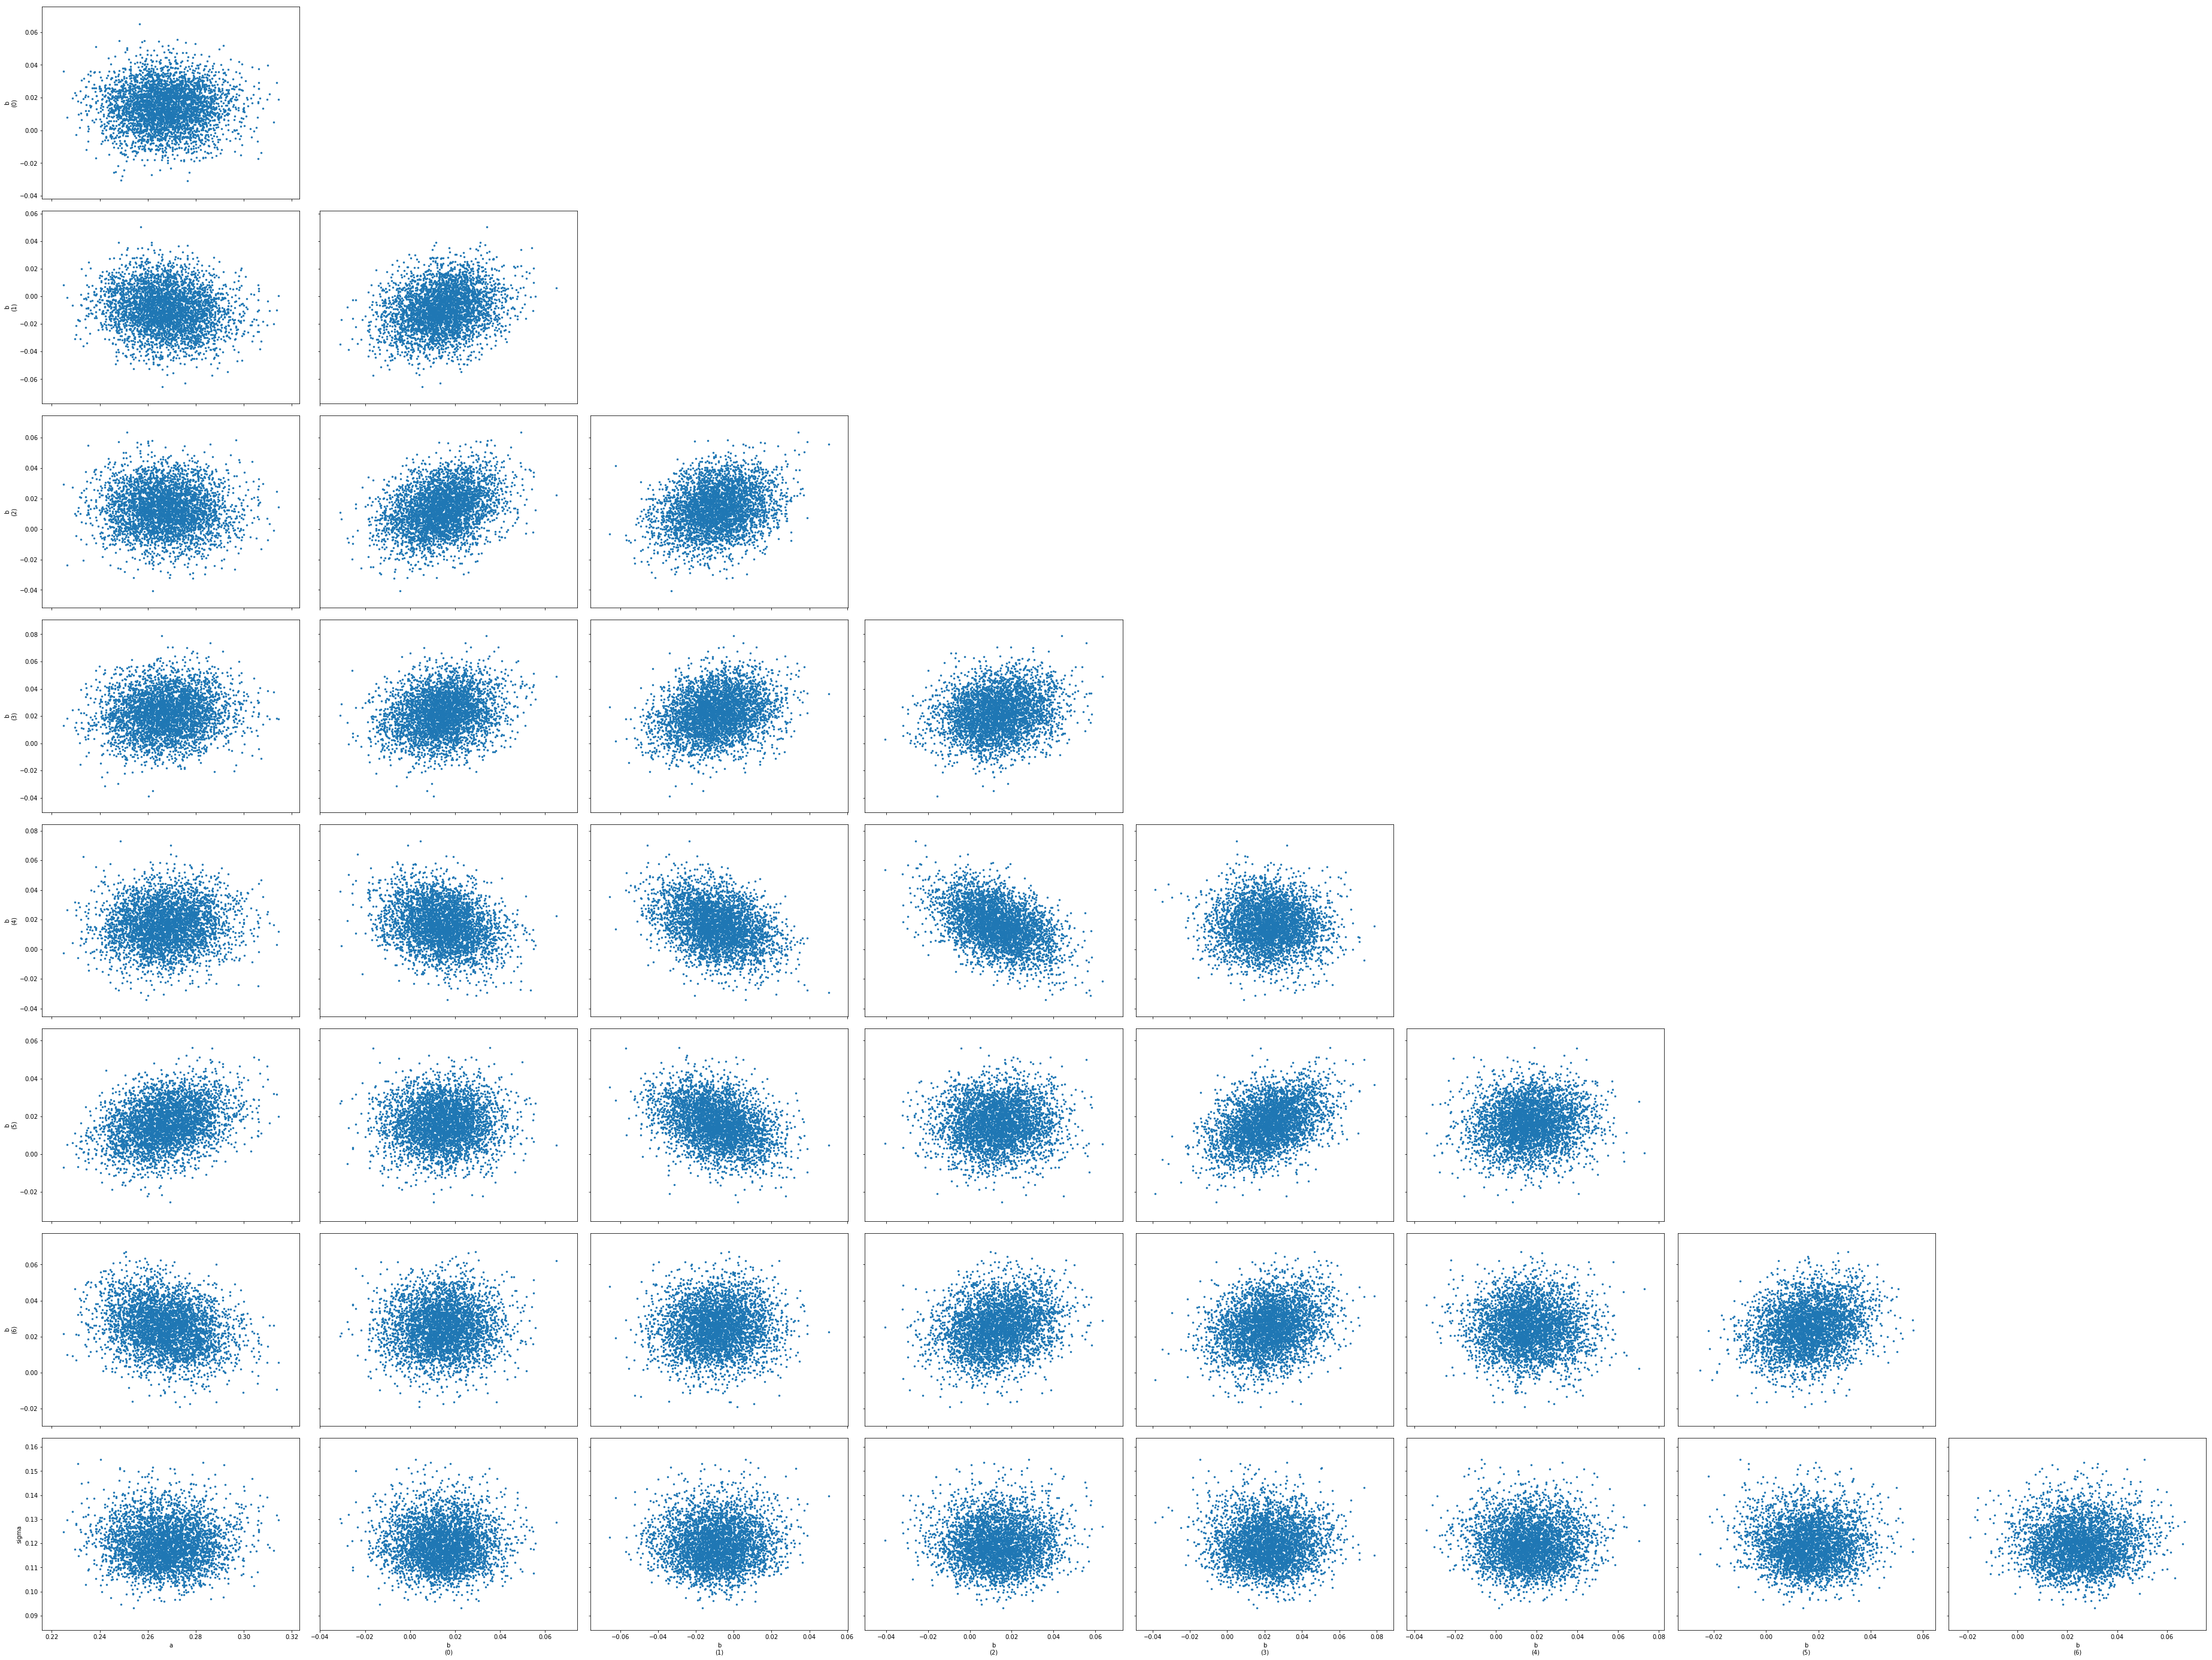

In [48]:
az.plot_pair(azpos)

### __Model check__ | PSIS-LOO

In [49]:
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data='y', 
                       posterior_predictive='ypred', 
                       log_likelihood='log_lik')
az.loo(azfit)

/home/zenist/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
/home/zenist/anaconda3/lib/python3.6/site-packages/arviz/stats/diagnostics.py:140: RuntimeWarning: invalid value encountered in true_divide
  acorr /= acorr[0]
/home/zenist/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/home/zenist/anaconda3/lib/python3.6/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        i

loo       loo_se        p_loo  warning
0 -3881.555915  6005.448766  7405.696576        1

### __Predictive accuracy__ | Predict streams for 2018

/home/zenist/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


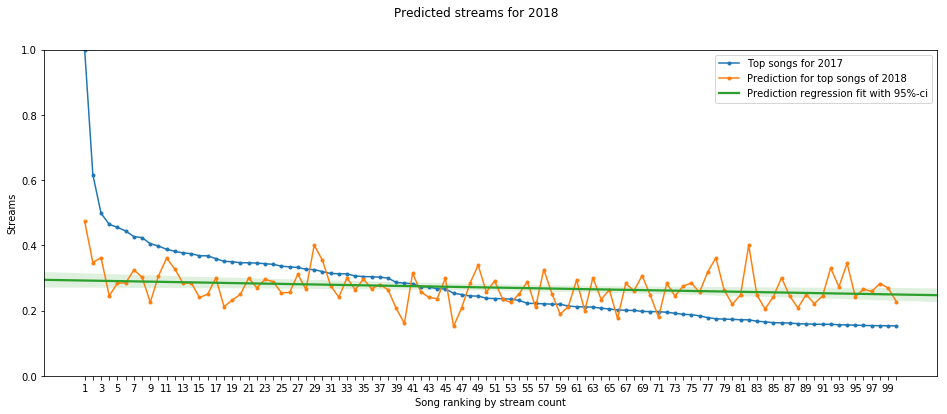

In [60]:
plt.figure(figsize=(16,6))

plt.suptitle('Predicted streams for 2018')
plt.xlabel('Song ranking by stream count')
plt.ylabel('Streams')

plt.ylim(0,1)
plt.xticks(range(1,101),labels=['{0}'.format(i) if i % 2 != 0 else '' for i in range(1,101)])
X_top100 = range(1,101)

plt.plot(X_top100, global_data['streams'], '.-', label='Top songs for 2017')
plt.plot(X_top100, np.mean(samples['ypred'], axis=0),  '.-', label='Prediction for top songs of 2018')
sns.regplot(list(X_top100), list(np.mean(samples['ypred'], axis=0)), 'o-', scatter=False, label='Prediction regression fit with 95%-ci')
plt.legend(loc='best')

## __2.5 Extended model 2__ | Adding second order polynomials
We will now relax the linearity assumptions even further by adding higher order polynomial terms.

This model will have 5 predictors with normal priors, two interaction terms and newly introduced second order terms.
Complete model takes the form:

$$ Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5 + \beta_6 X_1^2 + \beta_7 X_2^2 + \beta_8 X_3^2 + \beta_9 X_4^2 + \beta_{10} X_5^2 + \beta_{11} X_2 X_4 + \beta_{12} X_3 X_5, \;\sigma)$$

We also extend our Zellner's priors accordingly.

### __Load model__

In [78]:
filename = 'lin_5_informative-second_order.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // loudness
    vector[N] X4; // tempo
    vector[N] X5; // valence

    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    vector[Npred] X4pred;
    vector[Npred] X5pred;
    
    // prior means 
    real mu_a;
    vector[12] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[12] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    vector[N] X2X4;
    vector[N] X3X5;
    vector[N] X11;
    vector[N] X22;
    vector[N] X33;
    vector[N] X44;
    vector[N] X55;
    
    X11 = X1 .* X1;
    X22 = X2 .* X2;
    X33 = X3 .* X3;
    X44 = X4 .* X4;
    X55 = X5 .* X5;
    
    X2X4 = X2 .* X4;
    X3X5 = X3 .* X5;
    
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3 + 

In [79]:
gb_2017 = global_data.values
gb_2018 = global_data.values # We need to query the API for 2018 data and pre-process it. Finnish data is used for demonstration. 
data = dict(N=gb_2017.shape[0],
            y=gb_2017[:,0],
            X1=gb_2017[:,1], X2=gb_2017[:,2], X3=gb_2017[:,4], X4=gb_2017[:,5], X5=gb_2017[:,6],
            Npred=gb_2018.shape[0], 
            X1pred=gb_2018[:,1], X2pred=gb_2018[:,2], X3pred=gb_2018[:,4], X4pred=gb_2018[:,5], X5pred=gb_2018[:,6],
            mu_a=0,
            mu_b=np.zeros(12),
            sigma_0=0.12*10)

### __Fit model__

In [81]:
# Load compiled model if available
fit = None
try:
  fit = load_model('lin_5_informative-second_order.stan.saved')
except Exception: 
  fit = pystan.stan(file=filename, data=data, seed=42)
  save_model(fit, filename + '.saved')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2d5b7577dc304a3aff7b350232a7267c NOW.
/home/zenist/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  after removing the cwd from sys.path.


In [82]:
samples = fit.extract(permuted=True)

### __Simulation results__ | Posterior

In [83]:
summary = fit.summary(pars = ['a','b','sigma','ypred',]) 
fit_sum = pd.DataFrame(summary['summary'],
                  index=summary['summary_rownames'],
                  columns = summary['summary_colnames'])

fit_sum.iloc[0:14,0:10]

mean        se_mean            sd          2.5%           25%  \
a     -2.529110e-03       0.011981  1.223763e+00 -2.389718e+00 -8.466914e-01   
b[1]   4.616780e-03       0.012145  1.203798e+00 -2.334899e+00 -8.075100e-01   
b[2]   6.908860e-03       0.012840  1.210275e+00 -2.397410e+00 -8.078269e-01   
b[3]   1.380342e-02       0.011357  1.221653e+00 -2.375340e+00 -8.306661e-01   
b[4]  -1.298205e-02       0.012804  1.229430e+00 -2.423176e+00 -8.556333e-01   
b[5]  -1.063886e-02       0.013246  1.181808e+00 -2.347372e+00 -8.079211e-01   
b[6]   2.316883e-03       0.011085  1.219437e+00 -2.326048e+00 -8.528480e-01   
b[7]  -1.587070e-02       0.012649  1.219693e+00 -2.328803e+00 -8.619045e-01   
b[8]   1.459113e-03       0.011866  1.172888e+00 -2.282036e+00 -7.781797e-01   
b[9]   2.037406e-02       0.012631  1.200309e+00 -2.365468e+00 -7.881957e-01   
b[10]  1.350096e-02       0.011336  1.205946e+00 -2.346214e+00 -8.130076e-01   
b[11] -7.888159e-03       0.011876  1.148774e+00 -2.239212e+00 -7.891658e-01   
b[12] -1.670462e-02       0.013046  1.182176e+00 -2.288376e+00 -8.309563e-01   
sigma  4.469937e+08  343110.300957  3.160874e+07  3.912747e+08  4.255250e+08   

                50%           75%         97.5%         n_eff      Rhat  
a      1.117287e-02  8.552450e-01  2.373548e+00  10433.070305  0.999817  
b[1]   4.469938e-03  7.956483e-01  2.432857e+00   9824.557515  0.999335  
b[2]   9.823836e-03  8.277575e-01  2.392980e+00   8884.888808  0.999289  
b[3]   3.647843e-02  8.108461e-01  2.410715e+00  11570.149193  0.999258  
b[4]   3.883710e-03  8.227503e-01  2.372856e+00   9220.278708  0.999114  
b[5]   1.149682e-03  7.612444e-01  2.338529e+00   7960.333786  0.999381  
b[6]  -1.829259e-02  8.515313e-01  2.394360e+00  12101.836348  0.999205  
b[7]  -9.207301e-03  8.396618e-01  2.409271e+00   9297.436128  0.999647  
b[8]  -1.438505e-02  7.921438e-01  2.332509e+00   9770.941448  0.999530  
b[9]   2.144263e-02  8.277580e-01  2.380939e+00   9030.630876  0.999548  
b[10]  2.237761e-02  8.129443e-01  2.423802e+00  11316.963077  0.999374  
b[11] -1.270136e-02  7.956637e-01  2.235517e+00   9357.068017  0.999240  
b[12] -1.321859e-02  7.806010e-01  2.344232e+00   8211.425214  0.999116  
sigma  4.450061e+08  4.660923e+08  5.150568e+08   8486.856275  0.999433

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efcbe2d9860>,
      dtype=object)

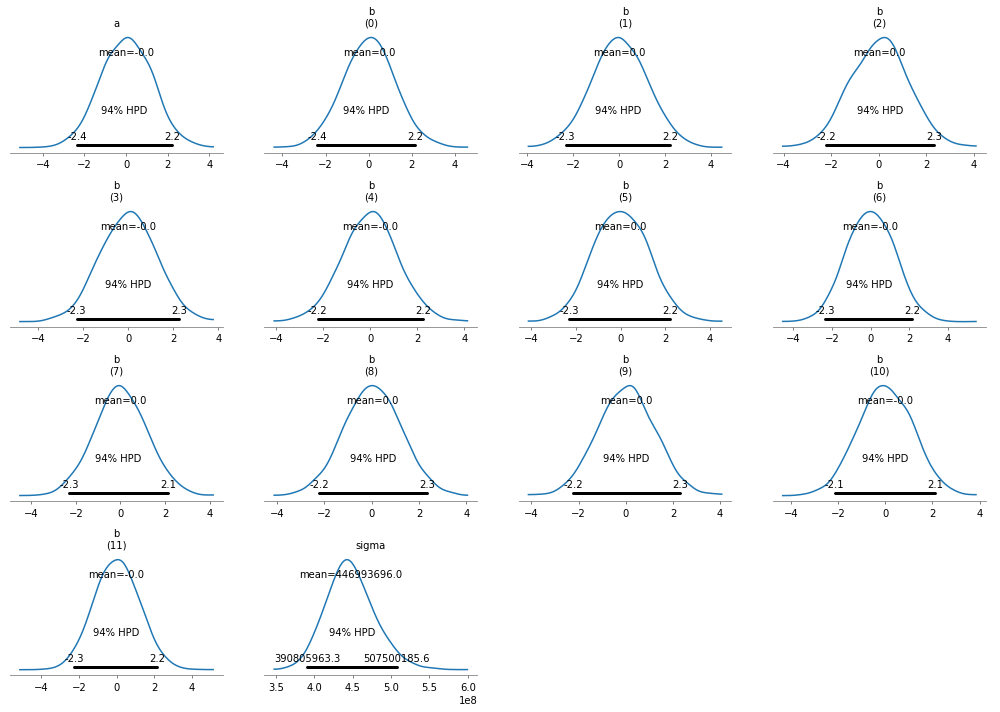

In [84]:
prior_dict = fit.extract(pars=['a','b','sigma'], permuted=False)
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data=['y'], 
                       posterior_predictive=['ypred'], 
                       log_likelihood=fit['log_lik'])
azpos = azfit.posterior[['a','b','sigma']]
az.plot_posterior(azpos, figsize=(14,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efca6ad2b00>,
      dtype=object)

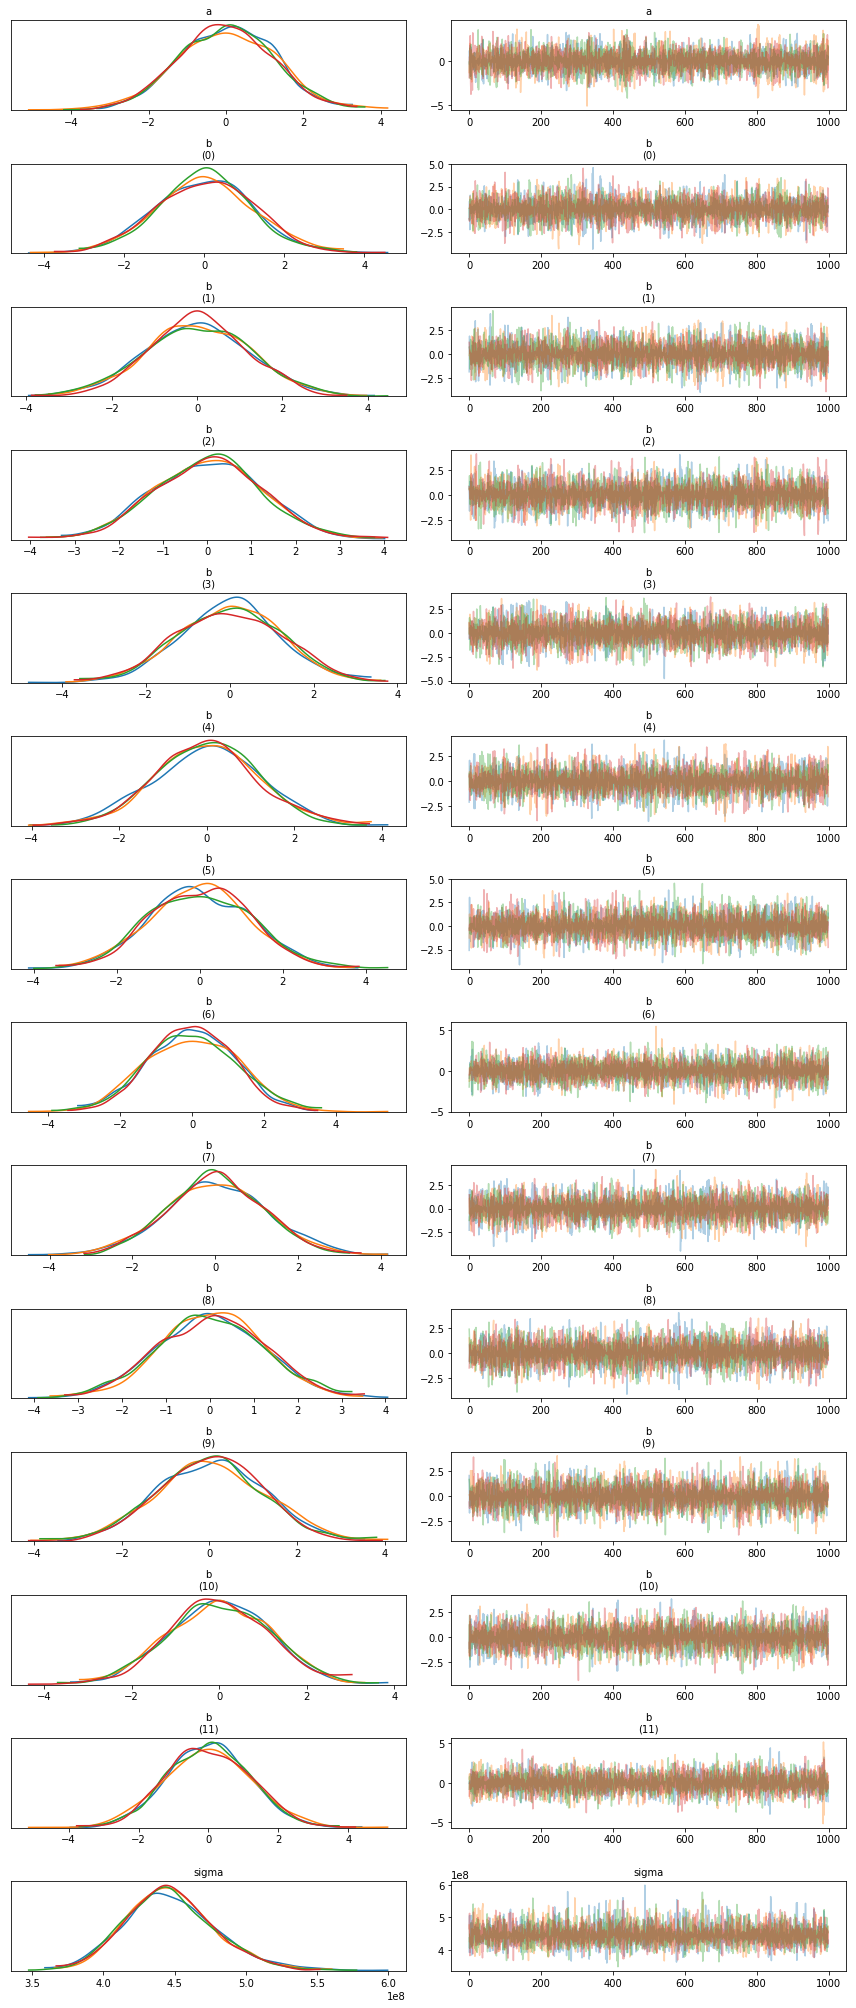

In [85]:
az.plot_trace(azpos)

In [ ]:
az.plot_pair(azpos)

(<matplotlib.axes._subplots.AxesSubplot at 0x7efcc2406e80>, GridSpec(13, 13))

### __Model check__ | PSIS-LOO

In [ ]:
azfit = az.from_pystan(fit=fit, prior=prior_dict, 
                       observed_data='y', 
                       posterior_predictive='ypred', 
                       log_likelihood='log_lik')
az.loo(azfit)

### __Predictive accuracy__ | Predict streams for 2018

In [ ]:
plt.figure(figsize=(16,6))

plt.suptitle('Predicted streams for 2018')
plt.xlabel('Song ranking by stream count')
plt.ylabel('Streams')

plt.ylim(0,1)
plt.xticks(range(1,101),labels=['{0}'.format(i) if i % 2 != 0 else '' for i in range(1,101)])
X_top100 = range(1,101)

plt.plot(X_top100, global_data['streams'], '.-', label='Top songs for 2017')
plt.plot(X_top100, np.mean(samples['ypred'], axis=0),  '.-', label='Prediction for top songs of 2018')
sns.regplot(list(X_top100), list(np.mean(samples['ypred'], axis=0)), 'o-', scatter=False, label='Prediction regression fit with 95%-ci')
plt.legend(loc='best')

In [ ]:
[pystan.diagnostics.check_treedepth(fit),
 pystan.diagnostics.check_div(fit),
 pystan.diagnostics.check_energy(fit),  
]

In [ ]:
[pystan.diagnostics.check_rhat(fit), pystan.diagnostics.check_n_eff(fit)]

## __3. Model Comparison__
Load all models.


In [190]:
model_filenames = ['lin_3_uninformative.stan.saved',
                   'lin_3_informative.stan.saved',
                   'lin_5_informative.stan.saved',
                   'lin_5_informative-interaction.stan.saved']

model_names = ['3 Predictors Uninformative',
               '3 Predictors Informative, Normal',
               '5 Predictors Informative, Normal',
               '5 Predictors Informative inter, Normal']

models = [load_model(M_name) for M_name in model_filenames]

Calculate PSIS-LOO-values:

In [248]:
params = ['α','β_1','β_2','β_3','β_4','β_5','β_6','β_7','sigma']
params_mean =  [e + ' | μ' for e in params]
params_stds =  [e + ' | σ' for e in params]
df = pd.DataFrame(columns=[params_mean + params_stds])

loo       loo_se       p_loo  warning (α | μ,) (β_1 | μ,)  \
0 -3597.04373  5961.645286  7682.61895        1      NaN        NaN   

  (β_2 | μ,) (β_3 | μ,) (β_4 | μ,) (β_5 | μ,)     ...      (sigma | μ,)  \
0        NaN        NaN        NaN        NaN     ...               NaN   

  (α | σ,) (β_1 | σ,) (β_2 | σ,) (β_3 | σ,) (β_4 | σ,) (β_5 | σ,) (β_6 | σ,)  \
0      NaN        NaN        NaN        NaN        NaN        NaN        NaN   

  (β_7 | σ,) (sigma | σ,)  
0        NaN          NaN  

[1 rows x 22 columns]

In [251]:
from functools import reduce
loos = []
params = ['α','β_1','β_2','β_3','β_4','β_5','β_6','β_7','sigma']

for M in models:
    azfit = az.from_pystan(fit=M, prior=prior_dict, 
                           observed_data='y', 
                           posterior_predictive='ypred', 
                           log_likelihood='log_lik')
    df_M = az.loo(azfit)
    
    m_s = []
    for func in [lambda X: np.mean(X), lambda X: np.var(X)]:
        m_s.append([func(M['a'])] + [func(M['b'][:,i]) for i in range(M['b'].shape[1])] + [func(M['sigma'])])
    
    df_M = pd.concat([df_M,df],axis=1)
    df_M.loc[params_mean] = m_s[0]
    df_M.loc[params_stds] = m_s[1]
    loos.append(df_M)

loos_merged = reduce(lambda left,right: pd.concat([left,right], axis=0), loos)

/home/mrreflex/anaconda3/envs/bdaproject/lib/python3.7/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal posterior and LOO posterior
        are very different. This is more likely to happen with a non-robust model and highly
        influential observations.
  influential observations."""


KeyError: "['α | μ' 'β_1 | μ' 'β_2 | μ' 'β_3 | μ' 'β_4 | μ' 'β_5 | μ' 'β_6 | μ'\n 'β_7 | μ' 'sigma | μ'] not in index"

In [250]:
loos_merged.set_axis(model_names, axis=0, inplace=True)
loos_merged

loo       loo_se        p_loo  \
3 Predictors Uninformative             -5096.359694  5532.216878  7362.516070   
3 Predictors Informative, Normal       -6133.387852  5467.369648  6585.259986   
5 Predictors Informative, Normal       -4655.450268  5840.526255  7195.049404   
5 Predictors Informative inter, Normal -3597.043730  5961.645286  7682.618950   

                                        warning (α | μ,) (β_1 | μ,)  \
3 Predictors Uninformative                    1      NaN        NaN   
3 Predictors Informative, Normal              1      NaN        NaN   
5 Predictors Informative, Normal              1      NaN        NaN   
5 Predictors Informative inter, Normal        1      NaN        NaN   

                                       (β_2 | μ,) (β_3 | μ,) (β_4 | μ,)  \
3 Predictors Uninformative                    NaN        NaN        NaN   
3 Predictors Informative, Normal              NaN        NaN        NaN   
5 Predictors Informative, Normal              NaN        NaN        NaN   
5 Predictors Informative inter, Normal        NaN        NaN        NaN   

                                       (β_5 | μ,)     ...      (sigma | μ,)  \
3 Predictors Uninformative                    NaN     ...               NaN   
3 Predictors Informative, Normal              NaN     ...               NaN   
5 Predictors Informative, Normal              NaN     ...               NaN   
5 Predictors Informative inter, Normal        NaN     ...               NaN   

                                       (α | σ,) (β_1 | σ,) (β_2 | σ,)  \
3 Predictors Uninformative                  NaN        NaN        NaN   
3 Predictors Informative, Normal            NaN        NaN        NaN   
5 Predictors Informative, Normal            NaN        NaN        NaN   
5 Predictors Informative inter, Normal      NaN        NaN        NaN   

                                       (β_3 | σ,) (β_4 | σ,) (β_5 | σ,)  \
3 Predictors Uninformative                    NaN        NaN        NaN   
3 Predictors Informative, Normal              NaN        NaN        NaN   
5 Predictors Informative, Normal              NaN        NaN        NaN   
5 Predictors Informative inter, Normal        NaN        NaN        NaN   

                                       (β_6 | σ,) (β_7 | σ,) (sigma | σ,)  
3 Predictors Uninformative                    NaN        NaN          NaN  
3 Predictors Informative, Normal              NaN        NaN          NaN  
5 Predictors Informative, Normal              NaN        NaN          NaN  
5 Predictors Informative inter, Normal        NaN        NaN          NaN  

[4 rows x 22 columns]

array([ 0.26725445,  0.01440413, -0.00924964,  0.01309549,  0.12001084])

Use leave-one-out cross validation (LOO-CV) to assess the predictive performance of the different models.

>* PSIS-LOO values, the effective number of parameters peff , and the k-values for each of the
three models

>* an assessment of how reliable the PSIS-LOO estimates are for the three models based on
the k-values

>* an assessment of whether there are differences between the models, and if so, which model
should be selected according to PSIS-LOO

>* number of effective parameters

## __4. Conclusions__
>  Even the coin tosses and die rolls ubiquitous in probability theory texts are not truly exchangeable. The more relevant question is, ‘Do the model’s deficiencies have a noticeable effect on the substantive inferences?’
p 142


>More formally, we can check a model by external validation using the model to make predic-
tions about future data, and then collecting those data and comparing to their predictions.
Posterior means should be correct on average, 50% intervals should contain the true values
half the time, and so forth. p. 143

See the hierarchical regression model: 142->

__Notes:__
Would the results be easier to interpret if we would normalize the streams to interval [0,1]?

We need to conduct proper sensitivity analysis using different priors and try to develop intuition about the data / hypothesize with more clarity. How to formulate reasonable priors for quite arbitrary linear coefficients $\beta$? Explaining the steepness of slope... 

Also we should think about how to construct hierarchical priors based on earlier data (weekly top 100). Also develop understanding about the make-up off global data - differing countries with differing cultures. For example chinese or italian music could be quite different compared to UK music. We should also train on Finnish and Swedish data and compare cultural differences by comparing posteriors. 